In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Building the data**
Useful parameters:


*   dataset name, x_axis, y_axis
*   input and output length
*   train ratio begin and end is used for LocalTrainData, GlobalTrainData
*   test ratio begin and end is used for LocalTestData, GlobalTestData
*   predictionSampleRatio is used for the local and global prediction datasets?
*   trainAttackerBegin is used to train the attacker's model
*   train_normalization and test_normalization are for the normalization of the data
*   trainingInterval: the size of the batch in terms of time




In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import numpy as np # linear algebra
import os
import sys
import time
import gc
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import datetime
import tensorflow as tf

# notebook_path = os.path.abspath("AdaptiveSingleLocalModel.ipynb")
sys.path.append('/content/drive/MyDrive/AdaVFL-GitHub')
from Data import MakeTrainingTimes, CheckLocalTrainData, CheckLocalPredictionData, GenerateRandomSamples, LocalSequentialDataset, LocalSampledDataset, GlobalSequentialDataset, GlobalSampledDataset, build_adjMatrix, MakeAttackTimes
from federationarguments import arguments

args = arguments()
if(args.dataset == "bikeNYC"):
    link = "https://drive.google.com/drive/folders/1diJwebRNa5AQ16Jy6eHNGtYGmIGeqcrt"
    args.trainingInterval = 24*60*60*1000
    args.batch_size = 97
    args.overall_size = 2870
    args.x_axis = 8
    args.y_axis = 16
else:
    if(args.dataset == "Yelp"):
        link = "https://drive.google.com/drive/folders/1K2Y_txKAda0TOEEDYvoa7sPPMYLCXI-U"
        args.trainingInterval = 8*24*60*60*1000
        args.batch_size = 32
        args.overall_size = 1085
        args.x_axis = 8
        args.y_axis = 8
    else:
        raise SystemError('Invalid data folder')  

fluff, folder = link.split('folders/')
#print (id) 
filePath = "'%s' in parents and trashed=false" %folder
print(filePath)
downloaded = drive.ListFile({'q':filePath}).GetList()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
  args.device_name = 'cuda'
  torch.cuda.set_device(0)
else:
  args.device_name = 'cpu'

LocalTrainData = []
LocalValidationData = []
LocalTestData = []
LocalPredictionSamples = {}
# GlobalPredictionSamples = GlobalSampledDataset(args)
# GlobalTestData = GlobalSequentialDataset(args,args.testRatioBegin,args.testRatioEnd)
# GlobalTrainData = GlobalSequentialDataset(args,args.trainRatioBegin,args.trainRatioEnd)
# AttackerTrainData = GlobalSequentialDataset(args,args.trainAttackerBegin,args.trainAttackerEnd)
# attacker_test_dataset = GlobalSampledDataset(args)

sampled_list = []
sampledPrediction = True
if len(downloaded) > 0:
  sampledPrediction = True
  for file in downloaded:
    try:
        downloaded = drive.CreateFile({'id':file['id']}) 
        downloaded.GetContentFile(file['title'])  
        timestamps = pd.read_csv(file['title'])
        grid = file['title'].split(".")
        axis = grid[0].split("X")
        x_axis = int(axis[0])
        y_axis = int(axis[1])
        train = LocalSequentialDataset(timestamps,x_axis, y_axis, args.trainRatioBegin,args.trainRatioEnd, args)
        train.make_data()
        LocalTrainData.append(train)

        if(sampledPrediction == True):
            sampled_list = GenerateRandomSamples(timestamps, args)    
            sampledPrediction = False  

        predictsample = LocalSampledDataset(timestamps, x_axis, y_axis, args)
        predictsample.make_data(sampled_list)
        LocalValidationData.append(predictsample)
        LocalValidationData.append(predictsample)
        test = LocalSequentialDataset(timestamps,x_axis, y_axis, args.testRatioBegin,args.testRatioEnd, args)
        test.make_data()
        LocalTestData.append(test)
        sample_ID = str(x_axis)+"X"+str(y_axis)
        LocalPredictionSamples[sample_ID] = predictsample
        # GlobalTestData.add_data(name, timestamps)
        # GlobalTrainData.add_data(name, timestamps)
        # GlobalPredictionSamples.add_data(name, predictsample)
        # AttackerTrainData.add_data(name, timestamps)
        # attacker_test_dataset.add_data(name, predictsample)
    except Exception as e:
        print("hit an exception when making data ",e)
        exit('hit an exception when making data')    

# GlobalTestData.make_data()
# GlobalTestData.check_data()

# GlobalTrainData.make_data()
# GlobalTrainData.check_data()

# AttackerTrainData.make_data()
# GlobalTrainData.check_data()

## TODO: need to set the attacker start time and end time
# MakeAttackTimes(AttackerTrainData,args)
MakeTrainingTimes(LocalTrainData, args)

CheckLocalTrainData(LocalTrainData, args)

# CheckLocalPredictionData(LocalPredictionSamples, sampled_list)

# GlobalPredictionSamples.make_data()
# GlobalPredictionSamples.check_data()

# attacker_test_dataset.make_data()
# attacker_test_dataset.check_data()
print("len(LocalPredictionSamples)",len(LocalPredictionSamples))

adj = build_adjMatrix(args)

print("starting training time", datetime.datetime.fromtimestamp(args.start_training_time/1000).strftime('%Y-%m-%d %H:%M:%S'))
print("ending training time ", datetime.datetime.fromtimestamp(args.start_ending_time/1000).strftime('%Y-%m-%d %H:%M:%S'))

del sampled_list
del timestamps
gc.collect()


'1K2Y_txKAda0TOEEDYvoa7sPPMYLCXI-U' in parents and trashed=false
CheckLocalTrainData
beginningTime= 1514782799000
endingTime= 1538197199000
args.trainingInterval= 691200000
len(LocalPredictionSamples) 64
starting training time 2020-09-12 10:59:59
ending training time  2020-12-31 16:59:59


1168

**Privacy budget common initialization for all solutions**

In [6]:
sys.path.append('/content/drive/MyDrive/AdaVFL-GitHub')
from Data import generate_local_prediction, build_map,build_adjMatrix
from Models import GRU, MyGAT
import random
from WeightTools import (rho_to_sigma, sigma_to_rho,compute_advcomp_sigma, compute_advcomp_budget, 
                         rho_to_dp,compute_cumulated_budget, output_results, update_weights, pertub_weights, 
                         update_global_weights, Pair, test_model, update_budget_training, 
                         update_budget_accuracy , update_budget_increase, calculate_validation_accuracy,  
                         dp_to_zcdp, grad_func, noisyMax, perturb_gradients, compute_epsilon,
                         build_candidates, loss_score, override_model, grad_avg, sigma_to_epsilon, epsilon_to_sigma)
from tqdm import tqdm
import datetime

ratio = 1.
contribution = 1.
args.tracked_error = []

beginningTime = args.beginTrainingTimestamp
endingTime = args.endTrainingTimestamp
iterations = args.epochs*(((endingTime - beginningTime)//args.trainingInterval)+1)
  

if args.PrivacyMode != "None":
  total_epsilon = args.epsilon_0
  total_delta = args.delta_0
  total_rho = dp_to_zcdp(args.epsilon_0,args.delta_0)
  rho_t = total_rho/iterations
  if args.featureMode == "Uniform":
    if args.PrivacyMode == "Uniform":
      ## initialize with moments account
      # initial_sigma = args.sigma_0
      ## initialize with advanced composition
      epsilon_t, delta_t = compute_advcomp_budget(total_epsilon,total_delta,iterations)
      sigma_t = compute_advcomp_sigma(total_epsilon,total_delta,iterations)
      ## initialize with naive composition 
      # initial_budget = args.epsilon_0/iterations
      # initial_delta = args.delta_0/iterations
      # initial_sigma = compute_sigma(initial_budget,initial_delta)
    else:
        sigma_t = rho_to_sigma(rho_t)
        delta_t = total_delta/iterations
        epsilon_t = rho_to_dp(rho_t,delta_t)
  else:
    if args.featureMode == "InvContribution":
          alpha = (1./args.epsilon_0) - (1./args.epsilon_1)
          beta = 1./(args.epsilon_1+1.-(args.epsilon_1/args.epsilon_0))
          total_epsilon = 1./((alpha*feature_contribution_metrics[data.x_axis][data.y_axis])+((1.-alpha)*beta))
          total_delta = args.delta_0/feature_contribution_metrics[data.x_axis][data.y_axis]
          total_rho = dp_to_zcdp(total_epsilon,total_delta)
          rho_t = total_rho/iterations
          sigma_t = rho_to_sigma(rho_t)
          delta_t = total_delta/iterations
          epsilon_t = rho_to_dp(sigma_t,delta_t)
          privacy_budgets.append(sigma_t)
          print("initial_sigma",sigma_t)
    else:
      if args.featureMode == "LinContribution":
        beta = args.epsilon_1
        alpha = args.epsilon_0-beta
        total_epsilon = (alpha*feature_contribution_metrics[data.x_axis][data.y_axis])+beta
        total_delta = args.delta_0/feature_contribution_metrics[data.x_axis][data.y_axis]
        total_rho = dp_to_zcdp(total_epsilon,total_delta)
        rho_t = total_rho/iterations
        sigma_t = rho_to_sigma(rho_t)
        delta_t = total_delta/iterations
        epsilon_t = rho_to_dp(sigma_t,delta_t)
        privacy_budgets.append(sigma_t)
        print("initial_sigma",sigma_t)
      else:  
        print("a problem initializing the privacy budget ")
        exit('a problem initializing the privacy budget ')

  print("initial_budget", epsilon_t)
  print("initial_delta",delta_t)
  print("initial_sigma",sigma_t)
  print("total_rho",total_rho)


initial_budget 0.011336315657727723
initial_delta 2.450980392156863e-08
initial_sigma 124.26347490506106
total_rho 0.05203287039486121


**Initialize common variables**

In [7]:
assigned_epsilon = []
assigned_sigma = []
assigned_rho = []
cumulated_budget = 0.
number_of_training_rounds = 0

exec_average_local_training_loss = []
exec_average_local_RMSE = []
exec_average_local_WMAPE = []
exec_average_local_AE = []
local_training_accuracy_AE = []
local_training_accuracy_WMAPE = []
local_training_accuracy_RMSE = []
local_training_loss = []
local_loss_min = 1.
local_loss = 1.
Min_Loss_trashold = 0.016

device_model = GRU(args)

**Non-private and uniform only**

  3%|▎         | 1/34 [00:00<00:14,  2.29it/s]

local_loss  0.9623839768671221
local_loss  0.929860193883219



  9%|▉         | 3/34 [00:01<00:12,  2.54it/s]

local_loss  0.9724470896105613
local_loss  0.9372566342353821



 15%|█▍        | 5/34 [00:01<00:11,  2.59it/s]

local_loss  0.9196895091764389
local_loss  0.9179413174429247



 21%|██        | 7/34 [00:02<00:10,  2.63it/s]

local_loss  0.9501457079764335
local_loss  0.9650945874952501



 24%|██▎       | 8/34 [00:03<00:09,  2.63it/s]

local_loss  0.9486916353625636



 26%|██▋       | 9/34 [00:03<00:09,  2.61it/s]

local_loss  0.9158291095687497



 32%|███▏      | 11/34 [00:04<00:08,  2.60it/s]

local_loss  0.9622785449028015
local_loss  0.9459976563530583



 38%|███▊      | 13/34 [00:05<00:08,  2.61it/s]

local_loss  0.9289576267042468
local_loss  0.9292341066944984



 44%|████▍     | 15/34 [00:05<00:07,  2.65it/s]

local_loss  0.9617355312070539
local_loss  0.9455109373215707



 50%|█████     | 17/34 [00:06<00:06,  2.66it/s]

local_loss  0.944076064132875
local_loss  0.9592276427053636



 53%|█████▎    | 18/34 [00:06<00:06,  2.66it/s]

local_loss  0.9259859073546625



 59%|█████▉    | 20/34 [00:07<00:05,  2.64it/s]

local_loss  0.938517593911716
local_loss  0.9222687665493258



 62%|██████▏   | 21/34 [00:08<00:04,  2.63it/s]

local_loss  0.9040045084491852



 68%|██████▊   | 23/34 [00:08<00:04,  2.65it/s]

local_loss  0.9021115418403379
local_loss  0.9327095862357847



 71%|███████   | 24/34 [00:09<00:03,  2.64it/s]

local_loss  0.9152773003424367



 76%|███████▋  | 26/34 [00:09<00:02,  2.67it/s]

local_loss  0.9462921273323798
local_loss  0.8969652220126121



 79%|███████▉  | 27/34 [00:10<00:02,  2.64it/s]

local_loss  0.9440772764144405



 82%|████████▏ | 28/34 [00:10<00:02,  2.65it/s]

local_loss  0.9439189664779171



 88%|████████▊ | 30/34 [00:11<00:01,  2.64it/s]

local_loss  0.9117004775231884
local_loss  0.8957786175512499



 94%|█████████▍| 32/34 [00:12<00:00,  2.65it/s]

local_loss  0.9277289923160307
local_loss  0.8957762593223203



 97%|█████████▋| 33/34 [00:12<00:00,  2.65it/s]

local_loss  0.943924157850204



 17%|█▋        | 1/6 [00:12<01:04, 12.95s/it]

rho budget at epoch  0  is:  0.0011009356453751723
epsilon budget at epoch  0  is:  0.27889948375611306



  0%|          | 0/34 [00:00<?, ?it/s]

local_loss  0.9122309588616894



  6%|▌         | 2/34 [00:00<00:12,  2.62it/s]

local_loss  0.9284021181444968
local_loss  0.9290944366685806



 12%|█▏        | 4/34 [00:01<00:11,  2.59it/s]

local_loss  0.930167265476719
local_loss  0.9156306953199448



 15%|█▍        | 5/34 [00:01<00:11,  2.60it/s]

local_loss  0.9332304856469554



 21%|██        | 7/34 [00:02<00:10,  2.61it/s]

local_loss  0.9509487325145353
local_loss  0.9208935066576927



 24%|██▎       | 8/34 [00:03<00:10,  2.60it/s]

local_loss  0.938903255808738



 26%|██▋       | 9/34 [00:03<00:09,  2.62it/s]

local_loss  0.9566373209799489



 29%|██▉       | 10/34 [00:03<00:09,  2.62it/s]

local_loss  0.9585123177497618



 35%|███▌      | 12/34 [00:04<00:08,  2.62it/s]

local_loss  0.9123303246113562
local_loss  0.9618866655134386



 41%|████      | 14/34 [00:05<00:07,  2.61it/s]

local_loss  0.9637165877126879
local_loss  0.9493117717004591



 47%|████▋     | 16/34 [00:06<00:06,  2.64it/s]

local_loss  0.9504771809424123
local_loss  0.9677541698178938



 53%|█████▎    | 18/34 [00:06<00:06,  2.64it/s]

local_loss  0.9209476776661412
local_loss  0.9382769667333172



 59%|█████▉    | 20/34 [00:07<00:05,  2.66it/s]

local_loss  0.9554774453563075
local_loss  0.9727169698284518



 62%|██████▏   | 21/34 [00:07<00:04,  2.67it/s]

local_loss  0.9415009646646438



 68%|██████▊   | 23/34 [00:08<00:04,  2.65it/s]


local_loss  0.9563965361033168
local_loss  0.894450424178954


 74%|███████▎  | 25/34 [00:09<00:03,  2.64it/s]

local_loss  0.9427935356093992
local_loss  0.9269268858817316



 79%|███████▉  | 27/34 [00:10<00:02,  2.61it/s]

local_loss  0.9753358018013739
local_loss  0.9592837989330292



 85%|████████▌ | 29/34 [00:11<00:01,  2.62it/s]

local_loss  0.9595297536542339
local_loss  0.9438256852088436



 88%|████████▊ | 30/34 [00:11<00:01,  2.63it/s]

local_loss  0.960058000779921



 91%|█████████ | 31/34 [00:11<00:01,  2.64it/s]

local_loss  0.9764549789890167



 97%|█████████▋| 33/34 [00:12<00:00,  2.61it/s]

local_loss  0.9605985783761547
local_loss  0.928900650432033



 33%|███▎      | 2/6 [00:25<00:51, 12.98s/it]

rho budget at epoch  1  is:  0.0022018712907503446
epsilon budget at epoch  1  is:  0.3950683456365106



  0%|          | 0/34 [00:00<?, ?it/s]

local_loss  0.9293250633824256



  3%|▎         | 1/34 [00:00<00:12,  2.58it/s]

local_loss  0.9297561616666855



  6%|▌         | 2/34 [00:00<00:12,  2.58it/s]

local_loss  0.9463792472116409



 12%|█▏        | 4/34 [00:01<00:11,  2.60it/s]

local_loss  0.8986709810072376
local_loss  0.9313579211311955



 18%|█▊        | 6/34 [00:02<00:10,  2.60it/s]

local_loss  0.9640184246724651
local_loss  0.9000248822473711



 24%|██▎       | 8/34 [00:03<00:09,  2.62it/s]

local_loss  0.9650067110215464
local_loss  0.9495355573392683



 26%|██▋       | 9/34 [00:03<00:09,  2.61it/s]

local_loss  0.9823339658398782



 32%|███▏      | 11/34 [00:04<00:08,  2.60it/s]

local_loss  0.9651968596237046
local_loss  0.9839235678795846



 38%|███▊      | 13/34 [00:05<00:08,  2.59it/s]


local_loss  0.9361288143742469
local_loss  0.984925260466914


 44%|████▍     | 15/34 [00:05<00:07,  2.55it/s]

local_loss  0.9853057669055078
local_loss  0.9692687920985683



 47%|████▋     | 16/34 [00:06<00:06,  2.57it/s]

local_loss  0.9695192450477231



 50%|█████     | 17/34 [00:06<00:06,  2.57it/s]

local_loss  0.9384672699436065



 56%|█████▌    | 19/34 [00:07<00:05,  2.58it/s]

local_loss  0.9701179640908395
local_loss  0.954046796406469



 62%|██████▏   | 21/34 [00:08<00:05,  2.58it/s]

local_loss  0.9548784129081234
local_loss  0.9863615785875628



 65%|██████▍   | 22/34 [00:08<00:04,  2.57it/s]

local_loss  0.9862400677896315



 68%|██████▊   | 23/34 [00:08<00:04,  2.58it/s]

local_loss  0.9374517481173238



 74%|███████▎  | 25/34 [00:09<00:03,  2.55it/s]

local_loss  0.9694334576206822
local_loss  0.9850979447364807



 76%|███████▋  | 26/34 [00:10<00:03,  2.54it/s]

local_loss  0.9363436112480779



 79%|███████▉  | 27/34 [00:10<00:02,  2.53it/s]

local_loss  0.9522246305019625



 85%|████████▌ | 29/34 [00:11<00:01,  2.55it/s]

local_loss  0.9842280360960192
local_loss  0.9837477514820714



 91%|█████████ | 31/34 [00:12<00:01,  2.54it/s]

local_loss  0.902511312115577
local_loss  0.9664927365318421



 94%|█████████▍| 32/34 [00:12<00:00,  2.54it/s]

local_loss  0.9497216065083781



 97%|█████████▋| 33/34 [00:12<00:00,  2.52it/s]

local_loss  0.9812161845545615



 50%|█████     | 3/6 [00:39<00:39, 13.11s/it]

rho budget at epoch  2  is:  0.003302806936125517
epsilon budget at epoch  2  is:  0.4844640065327907



  0%|          | 0/34 [00:00<?, ?it/s]

local_loss  0.9495362562517966



  6%|▌         | 2/34 [00:00<00:12,  2.55it/s]

local_loss  0.9475933467188189
local_loss  0.9628839512025157



  9%|▉         | 3/34 [00:01<00:12,  2.55it/s]

local_loss  0.9458838076360764



 15%|█▍        | 5/34 [00:01<00:11,  2.53it/s]

local_loss  0.9611740631441916
local_loss  0.9765521980101063



 21%|██        | 7/34 [00:02<00:10,  2.52it/s]

local_loss  0.9757293058979896
local_loss  0.8944236732298328



 26%|██▋       | 9/34 [00:03<00:09,  2.51it/s]

local_loss  0.941917012776098
local_loss  0.9571072459220886



 32%|███▏      | 11/34 [00:04<00:09,  2.54it/s]

local_loss  0.9239863407227301
local_loss  0.9231683496505984



 38%|███▊      | 13/34 [00:05<00:08,  2.57it/s]

local_loss  0.9544834869523202
local_loss  0.9697676608639378



 44%|████▍     | 15/34 [00:05<00:07,  2.58it/s]

local_loss  0.9229105278368919
local_loss  0.9202000383407839



 50%|█████     | 17/34 [00:06<00:06,  2.56it/s]

local_loss  0.967747736361719
local_loss  0.9670614984727675



 56%|█████▌    | 19/34 [00:07<00:05,  2.56it/s]

local_loss  0.950252729077493
local_loss  0.9656955811285204



 62%|██████▏   | 21/34 [00:08<00:05,  2.56it/s]

local_loss  0.9329587163463715
local_loss  0.9647079417782445



 68%|██████▊   | 23/34 [00:09<00:04,  2.56it/s]

local_loss  0.9480265917316559
local_loss  0.9151709896902884



 74%|███████▎  | 25/34 [00:09<00:03,  2.51it/s]

local_loss  0.9466195952507758
local_loss  0.9298478999445515



 76%|███████▋  | 26/34 [00:10<00:03,  2.51it/s]

local_loss  0.961283851054407



 82%|████████▏ | 28/34 [00:11<00:02,  2.52it/s]

local_loss  0.9605080619935067
local_loss  0.9275041289867894



 88%|████████▊ | 30/34 [00:11<00:01,  2.51it/s]


local_loss  0.942751657578253
local_loss  0.9418027737448292


 94%|█████████▍| 32/34 [00:12<00:00,  2.52it/s]

local_loss  0.9086159929152458
local_loss  0.9075246905126879



 97%|█████████▋| 33/34 [00:13<00:00,  2.54it/s]

local_loss  0.9223978567507959



 67%|██████▋   | 4/6 [00:52<00:26, 13.23s/it]

rho budget at epoch  3  is:  0.004403742581500689
epsilon budget at epoch  3  is:  0.5600008388029765



  0%|          | 0/34 [00:00<?, ?it/s]

local_loss  0.953322833584201



  3%|▎         | 1/34 [00:00<00:13,  2.51it/s]

local_loss  0.9361475129281321



  9%|▉         | 3/34 [00:01<00:12,  2.57it/s]

local_loss  0.9349607969484022
local_loss  0.9177998746595075



 15%|█▍        | 5/34 [00:01<00:11,  2.53it/s]


local_loss  0.9489989492201036
local_loss  0.8997664518894688


 21%|██        | 7/34 [00:02<00:10,  2.51it/s]

local_loss  0.9148867908985384
local_loss  0.9459825619574516



 26%|██▋       | 9/34 [00:03<00:10,  2.50it/s]

local_loss  0.9288261869261342
local_loss  0.9439260709670282



 32%|███▏      | 11/34 [00:04<00:09,  2.50it/s]

local_loss  0.9146638493384084
local_loss  0.92595574259758



 35%|███▌      | 12/34 [00:04<00:08,  2.51it/s]

local_loss  0.9411213436434346



 41%|████      | 14/34 [00:05<00:07,  2.51it/s]

local_loss  0.9241734723890981
local_loss  0.9393118139236204



 47%|████▋     | 16/34 [00:06<00:07,  2.52it/s]

local_loss  0.906279303373829
local_loss  0.9213540342546278



 50%|█████     | 17/34 [00:06<00:06,  2.53it/s]

local_loss  0.9204151197787254



 53%|█████▎    | 18/34 [00:07<00:06,  2.53it/s]

local_loss  0.919313375026949



 56%|█████▌    | 19/34 [00:07<00:05,  2.53it/s]

local_loss  0.8860324121290638



 62%|██████▏   | 21/34 [00:08<00:05,  2.51it/s]

local_loss  0.8894154323685554
local_loss  0.8838879475670476



 65%|██████▍   | 22/34 [00:08<00:04,  2.50it/s]

local_loss  0.8989083891914736



 68%|██████▊   | 23/34 [00:09<00:04,  2.50it/s]

local_loss  0.9138894590639299



 71%|███████   | 24/34 [00:09<00:04,  2.34it/s]

local_loss  0.9128912418119369



 74%|███████▎  | 25/34 [00:10<00:04,  2.18it/s]

local_loss  0.9278384985462311



 76%|███████▋  | 26/34 [00:10<00:03,  2.08it/s]

local_loss  0.9107577704614208



 79%|███████▉  | 27/34 [00:11<00:03,  2.03it/s]

local_loss  0.9098743123392905



 82%|████████▏ | 28/34 [00:11<00:03,  1.88it/s]

local_loss  0.9089397067023862



 88%|████████▊ | 30/34 [00:12<00:02,  1.84it/s]

local_loss  0.8919479779658779
local_loss  0.8748962773430732



 91%|█████████ | 31/34 [00:13<00:01,  1.79it/s]

local_loss  0.8899993454256365



 94%|█████████▍| 32/34 [00:14<00:01,  1.81it/s]

local_loss  0.9050022613617682



 97%|█████████▋| 33/34 [00:14<00:00,  1.76it/s]

local_loss  0.9021324898515429



 83%|████████▎ | 5/6 [01:07<00:13, 13.94s/it]

rho budget at epoch  4  is:  0.005504678226875862
epsilon budget at epoch  4  is:  0.6266811158532316



  0%|          | 0/34 [00:00<?, ?it/s]

local_loss  0.8705514967441559



  6%|▌         | 2/34 [00:00<00:13,  2.31it/s]

local_loss  0.9176252734276557
local_loss  0.900432494378859



  9%|▉         | 3/34 [00:01<00:12,  2.39it/s]

local_loss  0.8993240114181272



 12%|█▏        | 4/34 [00:01<00:12,  2.41it/s]

local_loss  0.9144059285040824



 18%|█▊        | 6/34 [00:02<00:11,  2.46it/s]

local_loss  0.8650937099610606
local_loss  0.9123253995372403



 24%|██▎       | 8/34 [00:03<00:10,  2.47it/s]

local_loss  0.8790853033142705
local_loss  0.8779130164654024



 26%|██▋       | 9/34 [00:03<00:10,  2.47it/s]

local_loss  0.8606057772713323



 29%|██▉       | 10/34 [00:04<00:09,  2.47it/s]

local_loss  0.8914372651807724



 32%|███▏      | 11/34 [00:04<00:09,  2.48it/s]

local_loss  0.9062464910168802



 38%|███▊      | 13/34 [00:05<00:08,  2.47it/s]

local_loss  0.8888454533392384
local_loss  0.8714699822087442



 44%|████▍     | 15/34 [00:06<00:07,  2.48it/s]

local_loss  0.9022962085662349
local_loss  0.8850279354280041



 47%|████▋     | 16/34 [00:06<00:07,  2.46it/s]

local_loss  0.8837233166540822



 50%|█████     | 17/34 [00:06<00:06,  2.45it/s]

local_loss  0.8823976680155723



 56%|█████▌    | 19/34 [00:07<00:06,  2.46it/s]

local_loss  0.8811175188710613
local_loss  0.879901441835588



 62%|██████▏   | 21/34 [00:08<00:05,  2.47it/s]


local_loss  0.8948604464530945
local_loss  0.8776799325020083


 65%|██████▍   | 22/34 [00:08<00:04,  2.47it/s]


local_loss  0.8514567382874028


 71%|███████   | 24/34 [00:09<00:04,  2.46it/s]

local_loss  0.8913200612991087
local_loss  0.8419167716656962



 76%|███████▋  | 26/34 [00:10<00:03,  2.47it/s]

local_loss  0.8406099254085172
local_loss  0.8393822648832875



 79%|███████▉  | 27/34 [00:11<00:02,  2.44it/s]

local_loss  0.8703466307732367



 85%|████████▌ | 29/34 [00:11<00:02,  2.43it/s]

local_loss  0.8851964319905927
local_loss  0.8678972894145597



 91%|█████████ | 31/34 [00:12<00:01,  2.47it/s]

local_loss  0.8345413755985999
local_loss  0.8653656859551707



 97%|█████████▋| 33/34 [00:13<00:00,  2.47it/s]

local_loss  0.8399668037891388
local_loss  0.8627941935293136



100%|██████████| 6/6 [01:21<00:00, 13.62s/it]


rho budget at epoch  5  is:  0.006605613872251034
epsilon budget at epoch  5  is:  0.6870703080295627

 total cumulated_budget: 0.006605613872251034
local_loss_min, 0.8345413755985999

 Total Run Time: 81.7336
Training RMSEs 0.9196168812062556
0.9196168812062556
Training WMAPEs 0.9506494323996937
0.9506494323996937
Training AEs -0.8976882497469584
-0.8976882497469584


100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


Testing RMSEs 0.7481278250498989
0.8697209852970565
0.7718449003706113
0.6138268249039623
0.7926907733337436
0.8017652095402341
0.7683780762918184
0.627356259992054
0.7119290908880801
0.6597365224414953
0.864029607439934
Testing WMAPEs 0.8749485790729523
0.8837265968322754
0.8717741966247559
0.8603357076644897
0.8739326596260071
0.8753108978271484
0.8750528693199158
0.8763306736946106
0.8901830911636353
0.8582134246826172
0.8846256732940674
Testing AEs -0.6596144556999206
-0.8448784351348877
-0.7098031044006348
-0.4869007468223572
-0.7384337186813354
-0.7069959044456482
-0.693742036819458
-0.46950864791870117
-0.5504897832870483
-0.5574234127998352
-0.8379687666893005


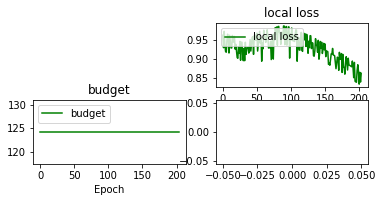

In [8]:
sys.path.append('/content/drive/MyDrive/AdaVFL-GitHub')
import math

# initialize variables for the training:
start_time = time.time()

## stop condition is the number of epochs
for epoch in tqdm(range(args.epochs)):

## stop condition is the total budget  
# while cumulated_budget < total_rho:

## stop condition is the loss threshold 
# while local_loss > Min_Loss_trashold:

  # if cumulated_budget >  total_rho:
  #   break
  # if local_loss <  Min_Loss_trashold:
  #   break
  # for timestamp in tqdm(range(beginningTime, endingTime, args.trainingInterval)):
  number_of_iterations = ((endingTime - beginningTime)//args.trainingInterval)+1
  for iteration in tqdm(range(number_of_iterations)):
    timestamp = random.randrange(beginningTime, endingTime, args.trainingInterval)
    # if local_loss <  Min_Loss_trashold:
    #   break
    # if cumulated_budget >  total_rho:
    #   break
    # train the local model
    # apply privacy if specified on the local model
    if args.PrivacyMode == "None":
        local_training_acc,local_loss = update_weights(timestamp, LocalTrainData[0], device_model, args)
    else:
      if args.PrivacyMode ==  "Uniform":
        privacy_budgets = sigma_t
        privacy_rho = sigma_to_rho(sigma_t)
        local_training_acc,local_loss = pertub_weights(timestamp, LocalTrainData[0], device_model,privacy_budgets, args)    
        assigned_sigma.append(privacy_budgets)

      adjusted_budget=rho_to_dp(privacy_rho,delta_t)   
      assigned_epsilon.append(adjusted_budget) 
      assigned_rho.append(privacy_rho) 

      cumulated_budget=compute_cumulated_budget(privacy_rho,cumulated_budget)
      if (local_loss_min > local_loss):
        local_loss_min = local_loss 
    local_training_loss.append(local_loss)
    print("local_loss ",local_loss)
    local_training_accuracy_AE.append(local_training_acc["AE"])
    local_training_accuracy_WMAPE.append(local_training_acc["WMAPE"])
    local_training_accuracy_RMSE.append(local_training_acc["RMSE"])
    number_of_training_rounds += 1
    torch.cuda.empty_cache()
    gc.collect()
  if args.PrivacyMode != "None":
    print("rho budget at epoch ",epoch," is: ",cumulated_budget)
    print("epsilon budget at epoch ",epoch," is: ",rho_to_dp(cumulated_budget,delta_t))

exec_average_local_training_loss.append(sum(local_training_loss)/ number_of_training_rounds)
exec_average_local_RMSE.append(sum(local_training_accuracy_RMSE) / number_of_training_rounds)
exec_average_local_WMAPE.append(sum(local_training_accuracy_WMAPE) / number_of_training_rounds)
exec_average_local_AE.append(sum(local_training_accuracy_AE) / number_of_training_rounds)
if args.PrivacyMode != "None":
  print("\n total cumulated_budget:",  cumulated_budget)

print("local_loss_min,",local_loss_min)

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

output_results(args,exec_average_local_RMSE,exec_average_local_WMAPE,exec_average_local_AE,
      device_model, LocalTestData, local_training_loss, assigned_sigma)


**Validation**


  0%|          | 0/30 [00:00<?, ?it/s]

validation_accuracy 0.18128420412540436


/home/fatimazahraerrounda/Downloads/AdaVFL/Models.py:119: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  per_sample_grad.add_(1.,torch.normal(mean=0, std=noise * self.args.clipping_threshold,size=per_sample_grad.shape))

  3%|▎         | 1/30 [00:01<00:48,  1.69s/it]

local_loss  0.19499311006317535
validation_accuracy 0.16900867223739624



  7%|▋         | 2/30 [00:03<00:47,  1.70s/it]

local_loss  0.18021824210882187
validation_accuracy 0.15836964547634125



 10%|█         | 3/30 [00:04<00:43,  1.62s/it]

local_loss  0.15827442767719427
validation_accuracy 0.1499231606721878



 13%|█▎        | 4/30 [00:06<00:41,  1.58s/it]

local_loss  0.17388774609814087
validation_accuracy 0.14271603524684906



 17%|█▋        | 5/30 [00:07<00:38,  1.55s/it]

local_loss  0.1540834524979194
validation_accuracy 0.1363198310136795



 20%|██        | 6/30 [00:09<00:36,  1.53s/it]

local_loss  0.14008460597445568
validation_accuracy 0.13080616295337677



 23%|██▎       | 7/30 [00:10<00:34,  1.51s/it]

local_loss  0.14155545240888992
validation_accuracy 0.12609070539474487



 27%|██▋       | 8/30 [00:12<00:32,  1.49s/it]

local_loss  0.11796278413385153
validation_accuracy 0.12164249271154404



 30%|███       | 9/30 [00:14<00:34,  1.66s/it]

local_loss  0.1158874159057935
validation_accuracy 0.11815305799245834
local_loss  0.15198895273109278



 33%|███▎      | 10/30 [00:16<00:34,  1.72s/it]

validation_accuracy 0.11533613502979279



 37%|███▋      | 11/30 [00:18<00:33,  1.78s/it]

local_loss  0.09066049071649711
validation_accuracy 0.11303339898586273



 40%|████      | 12/30 [00:19<00:32,  1.79s/it]

local_loss  0.11109894917656978
validation_accuracy 0.11148738116025925



 43%|████▎     | 13/30 [00:22<00:32,  1.92s/it]

local_loss  0.12684828011939922
validation_accuracy 0.11060483008623123



 47%|████▋     | 14/30 [00:24<00:30,  1.92s/it]

local_loss  0.12521141891678175
validation_accuracy 0.11022128164768219



 50%|█████     | 15/30 [00:25<00:28,  1.89s/it]

local_loss  0.12432733333359162
validation_accuracy 0.11048091948032379



 53%|█████▎    | 16/30 [00:27<00:26,  1.91s/it]

local_loss  0.12434691097587347
validation_accuracy 0.11121047288179398



 57%|█████▋    | 17/30 [00:29<00:24,  1.91s/it]

local_loss  0.16530571039766073
validation_accuracy 0.11220309883356094



 60%|██████    | 18/30 [00:31<00:21,  1.78s/it]

local_loss  0.1908415212916831
validation_accuracy 0.11351385712623596



 63%|██████▎   | 19/30 [00:33<00:20,  1.84s/it]

local_loss  0.12911383248865604
validation_accuracy 0.11517303436994553



 67%|██████▋   | 20/30 [00:34<00:18,  1.81s/it]

local_loss  0.14265697790930668
validation_accuracy 0.11708225309848785



 70%|███████   | 21/30 [00:36<00:16,  1.79s/it]

local_loss  0.012759857500592867
validation_accuracy 0.1194554939866066



 73%|███████▎  | 22/30 [00:38<00:13,  1.73s/it]

local_loss  0.07767423056066036
validation_accuracy 0.12203283607959747



 77%|███████▋  | 23/30 [00:39<00:11,  1.65s/it]

local_loss  0.11281292295704286
validation_accuracy 0.12531165778636932



 80%|████████  | 24/30 [00:41<00:10,  1.68s/it]

local_loss  0.11572896844396989
validation_accuracy 0.12897685170173645



 83%|████████▎ | 25/30 [00:43<00:09,  1.86s/it]

local_loss  0.14185902010649443
validation_accuracy 0.13229455053806305



 87%|████████▋ | 26/30 [00:45<00:07,  1.98s/it]

local_loss  0.07288420510788758
validation_accuracy 0.1353621780872345



 90%|█████████ | 27/30 [00:48<00:06,  2.02s/it]

local_loss  0.06922938209027052
validation_accuracy 0.13798373937606812



 93%|█████████▎| 28/30 [00:49<00:03,  1.95s/it]

local_loss  0.26075507203737897
validation_accuracy 0.1403319388628006



 97%|█████████▋| 29/30 [00:51<00:01,  1.85s/it]

local_loss  0.15089268734057745
validation_accuracy 0.14229868352413177
local_loss  0.26356479882573086



  0%|          | 0/30 [00:00<?, ?it/s]

validation_accuracy 0.1437443345785141
local_loss  0.16250081670780978



  3%|▎         | 1/30 [00:01<00:47,  1.63s/it]

validation_accuracy 0.14471670985221863



  7%|▋         | 2/30 [00:03<00:45,  1.63s/it]

local_loss  0.07778343589355548
validation_accuracy 0.14530830085277557



 10%|█         | 3/30 [00:04<00:44,  1.65s/it]

local_loss  0.18628414068371058
validation_accuracy 0.14539596438407898



 13%|█▎        | 4/30 [00:06<00:43,  1.68s/it]

local_loss  0.1558517130712668
validation_accuracy 0.14513002336025238



 17%|█▋        | 5/30 [00:08<00:41,  1.66s/it]

local_loss  0.07844535292436679
validation_accuracy 0.1444292664527893



 20%|██        | 6/30 [00:09<00:39,  1.64s/it]

local_loss  0.1681760447099805
validation_accuracy 0.1433822363615036



 23%|██▎       | 7/30 [00:11<00:37,  1.65s/it]

local_loss  0.2640250201802701
validation_accuracy 0.14188800752162933



 27%|██▋       | 8/30 [00:13<00:35,  1.63s/it]

local_loss  0.21220447781474092
validation_accuracy 0.14015991985797882



 30%|███       | 9/30 [00:14<00:34,  1.62s/it]

local_loss  0.21099123809226725
validation_accuracy 0.13830238580703735



 33%|███▎      | 10/30 [00:16<00:32,  1.62s/it]

local_loss  0.07951402788360913
validation_accuracy 0.13630898296833038



 37%|███▋      | 11/30 [00:18<00:30,  1.62s/it]

local_loss  0.15653091420729956
validation_accuracy 0.13404852151870728



 40%|████      | 12/30 [00:19<00:29,  1.61s/it]

local_loss  0.14000659498075643
validation_accuracy 0.13161472976207733



 43%|████▎     | 13/30 [00:21<00:28,  1.67s/it]

local_loss  0.1297691377500693
validation_accuracy 0.12911945581436157



 47%|████▋     | 14/30 [00:23<00:26,  1.66s/it]

local_loss  0.1283455907056729
validation_accuracy 0.12659674882888794



 50%|█████     | 15/30 [00:24<00:24,  1.65s/it]

local_loss  0.011770163973172506
validation_accuracy 0.12400547415018082



 53%|█████▎    | 16/30 [00:26<00:22,  1.64s/it]

local_loss  0.2507544447047015
validation_accuracy 0.12154120951890945



 57%|█████▋    | 17/30 [00:27<00:21,  1.63s/it]

local_loss  0.14401604452480873
validation_accuracy 0.1192365512251854



 60%|██████    | 18/30 [00:29<00:19,  1.63s/it]

local_loss  0.19461874423238137
validation_accuracy 0.11746028810739517



 63%|██████▎   | 19/30 [00:31<00:18,  1.65s/it]

local_loss  0.07770884099105994
validation_accuracy 0.11587211489677429
local_loss  0.1087826235840718



 67%|██████▋   | 20/30 [00:32<00:16,  1.67s/it]

validation_accuracy 0.11441101133823395



 70%|███████   | 21/30 [00:34<00:14,  1.66s/it]

local_loss  0.19044513014766076
validation_accuracy 0.11303923279047012



 73%|███████▎  | 22/30 [00:36<00:14,  1.76s/it]

local_loss  0.015038647999366125
validation_accuracy 0.11194000393152237



 77%|███████▋  | 23/30 [00:38<00:13,  1.88s/it]

local_loss  0.018508666505416233
validation_accuracy 0.1110619530081749



 80%|████████  | 24/30 [00:41<00:12,  2.01s/it]

local_loss  0.1175255694737037
validation_accuracy 0.11027476191520691



 83%|████████▎ | 25/30 [00:43<00:10,  2.17s/it]

local_loss  0.07529631877938907
validation_accuracy 0.10957399010658264



 87%|████████▋ | 26/30 [00:45<00:08,  2.19s/it]

local_loss  0.12120911478996277
validation_accuracy 0.10894959419965744



 90%|█████████ | 27/30 [00:48<00:06,  2.23s/it]

local_loss  0.14802244398742914
validation_accuracy 0.10838986933231354



 93%|█████████▎| 28/30 [00:51<00:04,  2.48s/it]

local_loss  0.13272305422772965
validation_accuracy 0.10790063440799713



 97%|█████████▋| 29/30 [00:53<00:02,  2.39s/it]

local_loss  0.18539551350959513
validation_accuracy 0.10746052116155624



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.07191920715073745
validation_accuracy 0.10709113627672195



  3%|▎         | 1/30 [00:01<00:52,  1.82s/it]

local_loss  0.12086484394967556
validation_accuracy 0.10679516196250916



  7%|▋         | 2/30 [00:03<00:50,  1.81s/it]

local_loss  0.13584630005061626
validation_accuracy 0.10654903203248978
local_loss  0.12231343984603882



 10%|█         | 3/30 [00:05<00:47,  1.76s/it]

validation_accuracy 0.1063876822590828



 13%|█▎        | 4/30 [00:06<00:45,  1.75s/it]

local_loss  0.05019061639904976
validation_accuracy 0.10629294812679291



 17%|█▋        | 5/30 [00:08<00:43,  1.73s/it]

local_loss  0.15482991049066186
validation_accuracy 0.106232650578022



 20%|██        | 6/30 [00:10<00:40,  1.70s/it]

local_loss  0.10310740644733112
validation_accuracy 0.10623094439506531



 23%|██▎       | 7/30 [00:11<00:38,  1.67s/it]

local_loss  0.23267324392994246
validation_accuracy 0.10628842562437057



 27%|██▋       | 8/30 [00:13<00:36,  1.68s/it]

local_loss  0.0809457606325547
validation_accuracy 0.10638381540775299



 30%|███       | 9/30 [00:15<00:35,  1.67s/it]

local_loss  0.18838385601217547
validation_accuracy 0.10651328414678574



 33%|███▎      | 10/30 [00:16<00:33,  1.66s/it]

local_loss  0.12152313720434904
validation_accuracy 0.1066495031118393



 37%|███▋      | 11/30 [00:18<00:31,  1.65s/it]

local_loss  0.08313510318597157
validation_accuracy 0.10679358243942261



 40%|████      | 12/30 [00:20<00:29,  1.66s/it]

local_loss  0.1300889772052566
validation_accuracy 0.10695336014032364



 43%|████▎     | 13/30 [00:21<00:28,  1.66s/it]

local_loss  0.1452255817130208
validation_accuracy 0.1071363165974617



 47%|████▋     | 14/30 [00:23<00:26,  1.68s/it]

local_loss  0.14195920495937267
validation_accuracy 0.10733766853809357



 50%|█████     | 15/30 [00:25<00:25,  1.69s/it]

local_loss  0.14205912873148918
validation_accuracy 0.10756777971982956



 53%|█████▎    | 16/30 [00:27<00:24,  1.78s/it]

local_loss  0.10672170079002778
validation_accuracy 0.1078111007809639
local_loss  0.11752650327980518



 57%|█████▋    | 17/30 [00:29<00:22,  1.77s/it]

validation_accuracy 0.10804861783981323



 60%|██████    | 18/30 [00:30<00:20,  1.73s/it]

local_loss  0.11792285429934661
validation_accuracy 0.10829399526119232



 63%|██████▎   | 19/30 [00:32<00:19,  1.77s/it]

local_loss  0.12151574684927861
validation_accuracy 0.10854458063840866



 67%|██████▋   | 20/30 [00:34<00:18,  1.86s/it]

local_loss  0.12618505768477917
validation_accuracy 0.10879570990800858



 70%|███████   | 21/30 [00:36<00:16,  1.82s/it]

local_loss  0.1324775299678246
validation_accuracy 0.10904962569475174



 73%|███████▎  | 22/30 [00:38<00:14,  1.83s/it]

local_loss  0.1843580117371554
validation_accuracy 0.10932324081659317



 77%|███████▋  | 23/30 [00:39<00:12,  1.80s/it]

local_loss  0.08394886739552021
validation_accuracy 0.10954707115888596



 80%|████████  | 24/30 [00:41<00:10,  1.77s/it]

local_loss  0.137303385262688
validation_accuracy 0.10976483672857285



 83%|████████▎ | 25/30 [00:43<00:08,  1.79s/it]

local_loss  0.09281140317519505
validation_accuracy 0.10995467007160187



 87%|████████▋ | 26/30 [00:45<00:07,  1.79s/it]

local_loss  0.13756071496754885
validation_accuracy 0.1101301908493042



 90%|█████████ | 27/30 [00:46<00:05,  1.71s/it]

local_loss  0.10256789810955524
validation_accuracy 0.11025605350732803



 93%|█████████▎| 28/30 [00:48<00:03,  1.81s/it]

local_loss  0.13777286062637964
validation_accuracy 0.1103711798787117



 97%|█████████▋| 29/30 [00:51<00:01,  1.94s/it]

local_loss  0.1833160682581365
validation_accuracy 0.11048046499490738



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.08940124604851007
validation_accuracy 0.11055416613817215



  3%|▎         | 1/30 [00:02<01:05,  2.27s/it]

local_loss  0.1256414003049334
validation_accuracy 0.11061106622219086



  7%|▋         | 2/30 [00:04<01:02,  2.24s/it]

local_loss  0.1041795052587986
validation_accuracy 0.11062009632587433



 10%|█         | 3/30 [00:06<01:00,  2.25s/it]

local_loss  0.11186785406122605
validation_accuracy 0.11060886085033417



 13%|█▎        | 4/30 [00:08<00:56,  2.19s/it]

local_loss  0.12567381591846546
validation_accuracy 0.11056666821241379



 17%|█▋        | 5/30 [00:10<00:52,  2.11s/it]

local_loss  0.12923738236228624
validation_accuracy 0.11051042377948761



 20%|██        | 6/30 [00:12<00:48,  2.02s/it]

local_loss  0.1287798440704743
validation_accuracy 0.11042841523885727



 23%|██▎       | 7/30 [00:14<00:44,  1.92s/it]

local_loss  0.13791681515673795
validation_accuracy 0.11032883077859879
local_loss  0.1265035935988029



 27%|██▋       | 8/30 [00:15<00:40,  1.85s/it]

validation_accuracy 0.11022471636533737



 30%|███       | 9/30 [00:17<00:37,  1.80s/it]

local_loss  0.12789897496501604
validation_accuracy 0.11009985208511353



 33%|███▎      | 10/30 [00:19<00:35,  1.77s/it]

local_loss  0.12373090411225955
validation_accuracy 0.1099630743265152



 37%|███▋      | 11/30 [00:21<00:35,  1.84s/it]

local_loss  0.12863039411604404
validation_accuracy 0.10981748253107071



 40%|████      | 12/30 [00:23<00:33,  1.88s/it]

local_loss  0.08731264434754848
validation_accuracy 0.10966017097234726



 43%|████▎     | 13/30 [00:25<00:31,  1.86s/it]

local_loss  0.086876950537165
validation_accuracy 0.1094721108675003



 47%|████▋     | 14/30 [00:26<00:28,  1.81s/it]

local_loss  0.14348930617173514
validation_accuracy 0.10927615314722061



 50%|█████     | 15/30 [00:28<00:28,  1.90s/it]

local_loss  0.08728932434072097
validation_accuracy 0.10905523598194122
local_loss  0.18311343322663257



 53%|█████▎    | 16/30 [00:30<00:27,  1.93s/it]

validation_accuracy 0.10885141789913177



 57%|█████▋    | 17/30 [00:32<00:24,  1.88s/it]

local_loss  0.11402727166811626
validation_accuracy 0.10864086449146271



 60%|██████    | 18/30 [00:34<00:22,  1.91s/it]

local_loss  0.13202181365340948
validation_accuracy 0.10842865705490112



 63%|██████▎   | 19/30 [00:36<00:21,  1.96s/it]

local_loss  0.12652902491390705
validation_accuracy 0.1082049161195755



 67%|██████▋   | 20/30 [00:38<00:18,  1.87s/it]

local_loss  0.10688774225612481
validation_accuracy 0.10798761993646622



 70%|███████   | 21/30 [00:39<00:15,  1.75s/it]

local_loss  0.18234918491784916
validation_accuracy 0.10777260363101959



 73%|███████▎  | 22/30 [00:41<00:13,  1.66s/it]

local_loss  0.11868167233963807
validation_accuracy 0.1075541228055954



 77%|███████▋  | 23/30 [00:42<00:11,  1.64s/it]

local_loss  0.10634665687878926
validation_accuracy 0.10733933001756668



 80%|████████  | 24/30 [00:44<00:09,  1.63s/it]

local_loss  0.12502050523956618
validation_accuracy 0.10712194442749023
local_loss  0.1821169233104835



 83%|████████▎ | 25/30 [00:45<00:07,  1.59s/it]

validation_accuracy 0.10690310597419739
local_loss  0.0747539425889651



 87%|████████▋ | 26/30 [00:47<00:06,  1.59s/it]

validation_accuracy 0.10665643960237503



 90%|█████████ | 27/30 [00:49<00:04,  1.57s/it]

local_loss  0.08672779922684033
validation_accuracy 0.10640455782413483



 93%|█████████▎| 28/30 [00:50<00:03,  1.55s/it]

local_loss  0.13475801019618908
validation_accuracy 0.10615784674882889



 97%|█████████▋| 29/30 [00:52<00:01,  1.56s/it]

local_loss  0.11686322310318549
validation_accuracy 0.10591958463191986



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.10560479698081811
validation_accuracy 0.1056869775056839



  3%|▎         | 1/30 [00:01<00:44,  1.54s/it]

local_loss  0.12376430165022612
validation_accuracy 0.10546296089887619



  7%|▋         | 2/30 [00:03<00:44,  1.60s/it]

local_loss  0.11616507824510336
validation_accuracy 0.10523738712072372



 10%|█         | 3/30 [00:04<00:42,  1.57s/it]

local_loss  0.12320330770065387
validation_accuracy 0.10502278804779053



 13%|█▎        | 4/30 [00:06<00:41,  1.59s/it]

local_loss  0.11174673028290272
validation_accuracy 0.10482174158096313



 17%|█▋        | 5/30 [00:08<00:40,  1.61s/it]

local_loss  0.18156042019836605
validation_accuracy 0.10463951528072357



 20%|██        | 6/30 [00:09<00:38,  1.62s/it]

local_loss  0.13341788947582245
validation_accuracy 0.10447074472904205



 23%|██▎       | 7/30 [00:11<00:39,  1.72s/it]

local_loss  0.12114826713999112
validation_accuracy 0.10432319343090057



 27%|██▋       | 8/30 [00:13<00:37,  1.69s/it]

local_loss  0.12208794678250949
validation_accuracy 0.10419057309627533



 30%|███       | 9/30 [00:14<00:35,  1.67s/it]

local_loss  0.08200247151156266
validation_accuracy 0.10407593846321106



 33%|███▎      | 10/30 [00:16<00:33,  1.67s/it]

local_loss  0.13215074129402637
validation_accuracy 0.10398535430431366



 37%|███▋      | 11/30 [00:18<00:31,  1.66s/it]

local_loss  0.14061687172700962
validation_accuracy 0.10392044484615326



 40%|████      | 12/30 [00:20<00:31,  1.77s/it]

local_loss  0.11184889388581117
validation_accuracy 0.10386856645345688



 43%|████▎     | 13/30 [00:21<00:29,  1.76s/it]

local_loss  0.07033700278649728
validation_accuracy 0.10383976250886917



 47%|████▋     | 14/30 [00:23<00:28,  1.76s/it]

local_loss  0.11944530780116717
validation_accuracy 0.10383728891611099



 50%|█████     | 15/30 [00:25<00:26,  1.74s/it]

local_loss  0.11212061283489068
validation_accuracy 0.10385747253894806



 53%|█████▎    | 16/30 [00:27<00:24,  1.74s/it]

local_loss  0.13302515322963396
validation_accuracy 0.10389868170022964



 57%|█████▋    | 17/30 [00:28<00:22,  1.74s/it]

local_loss  0.12673702587683996
validation_accuracy 0.10397204011678696



 60%|██████    | 18/30 [00:30<00:20,  1.73s/it]

local_loss  0.11888356289515893
validation_accuracy 0.10406725853681564



 63%|██████▎   | 19/30 [00:32<00:18,  1.72s/it]

local_loss  0.11283871966103713
validation_accuracy 0.1041724905371666



 67%|██████▋   | 20/30 [00:34<00:17,  1.71s/it]

local_loss  0.12634917503843704
validation_accuracy 0.10429991036653519



 70%|███████   | 21/30 [00:35<00:15,  1.70s/it]

local_loss  0.2337654734340807
validation_accuracy 0.10443608462810516



 73%|███████▎  | 22/30 [00:37<00:13,  1.72s/it]

local_loss  0.033627395828564964
validation_accuracy 0.10460198670625687



 77%|███████▋  | 23/30 [00:39<00:12,  1.72s/it]

local_loss  0.13466238820304474
validation_accuracy 0.1047968715429306



 80%|████████  | 24/30 [00:40<00:10,  1.75s/it]

local_loss  0.06561701403309901
validation_accuracy 0.10501878708600998



 83%|████████▎ | 25/30 [00:42<00:09,  1.81s/it]

local_loss  0.18246182116369405
validation_accuracy 0.10524746775627136



 87%|████████▋ | 26/30 [00:44<00:07,  1.77s/it]

local_loss  0.2353950448644658
validation_accuracy 0.10548529028892517



 90%|█████████ | 27/30 [00:46<00:05,  1.80s/it]

local_loss  0.11134620197117329
validation_accuracy 0.10573472827672958



 93%|█████████▎| 28/30 [00:48<00:03,  1.78s/it]

local_loss  0.02354757860302925
validation_accuracy 0.10603296756744385



 97%|█████████▋| 29/30 [00:49<00:01,  1.77s/it]

local_loss  0.1830731561017591
validation_accuracy 0.10636181384325027



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.1116714912156264
validation_accuracy 0.10669799894094467



  3%|▎         | 1/30 [00:01<00:50,  1.76s/it]

local_loss  0.06217362731695175
validation_accuracy 0.10708462446928024



  7%|▋         | 2/30 [00:03<00:49,  1.76s/it]

local_loss  0.13206074852496386
validation_accuracy 0.10749103873968124



 10%|█         | 3/30 [00:05<00:47,  1.75s/it]

local_loss  0.13243024703115225
validation_accuracy 0.1079116016626358



 13%|█▎        | 4/30 [00:07<00:45,  1.75s/it]

local_loss  0.1841025735872487
validation_accuracy 0.10835246741771698



 17%|█▋        | 5/30 [00:08<00:43,  1.76s/it]

local_loss  0.12622710845122734
validation_accuracy 0.10880696028470993



 20%|██        | 6/30 [00:10<00:42,  1.75s/it]

local_loss  0.11541152093559504
validation_accuracy 0.10926716774702072



 23%|██▎       | 7/30 [00:12<00:40,  1.74s/it]

local_loss  0.1338404438768824
validation_accuracy 0.10972761362791061



 27%|██▋       | 8/30 [00:13<00:37,  1.72s/it]

local_loss  0.18504888391078905
validation_accuracy 0.11019711196422577



 30%|███       | 9/30 [00:15<00:36,  1.73s/it]

local_loss  0.11647809700419505
validation_accuracy 0.11067310720682144



 33%|███▎      | 10/30 [00:17<00:35,  1.76s/it]

local_loss  0.07685692173739274
validation_accuracy 0.1111612617969513



 37%|███▋      | 11/30 [00:19<00:33,  1.77s/it]

local_loss  0.10560038002828757
validation_accuracy 0.11165180802345276
local_loss  0.1432337217653791



 40%|████      | 12/30 [00:21<00:33,  1.86s/it]

validation_accuracy 0.11228002607822418



 43%|████▎     | 13/30 [00:23<00:31,  1.83s/it]

local_loss  0.1188761442899704
validation_accuracy 0.11297111958265305



 47%|████▋     | 14/30 [00:24<00:28,  1.79s/it]

local_loss  0.12122853317608435
validation_accuracy 0.11368847638368607



 50%|█████     | 15/30 [00:26<00:26,  1.78s/it]

local_loss  0.1270506139844656
validation_accuracy 0.1144193485379219
local_loss  0.10853638344754775



 53%|█████▎    | 16/30 [00:28<00:24,  1.78s/it]

validation_accuracy 0.11513486504554749



 57%|█████▋    | 17/30 [00:30<00:23,  1.82s/it]

local_loss  0.1546086147427559
validation_accuracy 0.11582335829734802



 60%|██████    | 18/30 [00:32<00:22,  1.91s/it]

local_loss  0.12322790206720431
validation_accuracy 0.11650311946868896



 63%|██████▎   | 19/30 [00:34<00:21,  1.92s/it]

local_loss  0.14690327613304058
validation_accuracy 0.11718174815177917



 67%|██████▋   | 20/30 [00:36<00:19,  1.91s/it]

local_loss  0.12376763640592496
validation_accuracy 0.11784728616476059



 70%|███████   | 21/30 [00:38<00:17,  1.93s/it]

local_loss  0.20597082314391932
validation_accuracy 0.11847107112407684



 73%|███████▎  | 22/30 [00:40<00:15,  1.97s/it]

local_loss  0.06946368453403313
validation_accuracy 0.11904827505350113



 77%|███████▋  | 23/30 [00:42<00:14,  2.00s/it]

local_loss  0.12507499133547148
validation_accuracy 0.11958213895559311



 80%|████████  | 24/30 [00:44<00:12,  2.07s/it]

local_loss  0.12555704296876988
validation_accuracy 0.12008261680603027



 83%|████████▎ | 25/30 [00:46<00:10,  2.11s/it]

local_loss  0.19340158323215884
validation_accuracy 0.12055265158414841



 87%|████████▋ | 26/30 [00:48<00:08,  2.13s/it]

local_loss  0.07138681411743164
validation_accuracy 0.12096700072288513



 90%|█████████ | 27/30 [00:50<00:06,  2.09s/it]

local_loss  0.2482947756846746
validation_accuracy 0.12132121622562408



 93%|█████████▎| 28/30 [00:53<00:04,  2.11s/it]

local_loss  0.1470209682981173
validation_accuracy 0.12160743027925491



 97%|█████████▋| 29/30 [00:54<00:01,  1.98s/it]

local_loss  0.17010735409955183
validation_accuracy 0.12182912975549698
local_loss  0.07246255936721961



 10%|█         | 1/10 [00:00<00:01,  5.39it/s]


 total_budget: 0.052032870394861035
local_loss_min, 0.011770163973172506

 Total Run Time: 323.2041
Training RMSEs 0.18175616969064862
0.18175616969064862
Training WMAPEs 0.17859905276757976
0.17859905276757976
Training AEs 0.047986784302783136
0.047986784302783136


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


Testing RMSEs 0.2869106503780259
0.29352605582358365
0.3064823349518453
0.21563757845913825
0.23838517783610508
0.3564693913099945
0.3067077150269087
0.2632734184345501
0.3567853585880644
0.2462850614218195
0.28555441192824893
Testing WMAPEs 0.2761077105998993
0.3477093577384949
0.18661761283874512
0.13339008390903473
0.23947088420391083
0.3501431345939636
0.37216290831565857
0.29879164695739746
0.2933274209499359
0.2641504108905792
0.2753136456012726
Testing AEs 0.10774083621799946
0.14789210259914398
0.04862525314092636
0.034614209085702896
0.10723669826984406
0.11686007678508759
0.1785925030708313
0.13263355195522308
0.08959851413965225
0.11818883568048477
0.1031666174530983


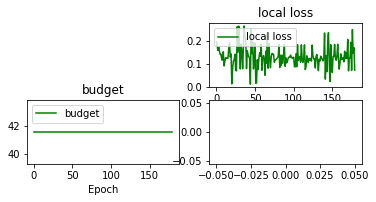

In [ ]:
start_time = time.time()

Validation_accuracy = []
Validation_accuracy =  np.full(args.validation_period, 0.) 

## stop condition is the number of epochs
for epoch in tqdm(range(args.epochs)):

## stop condition is the total budget  
# while cumulated_budget < total_rho:

## stop condition is the loss threshold 
# while local_loss > Min_Loss_trashold:

  # if cumulated_budget >  total_rho:
  #   break
  # if local_loss <  Min_Loss_trashold:
  #   break
  number_of_iterations = ((endingTime - beginningTime)//args.trainingInterval)+1
  for iteration in tqdm(range(number_of_iterations)):
    timestamp = random.randrange(beginningTime, endingTime, args.trainingInterval)
    # if local_loss <  Min_Loss_trashold:
    #   break
    # if cumulated_budget >  total_rho:
    #   break

    # train the local model
    # apply privacy if specified on the local model
    quotient = number_of_training_rounds // args.epoch_period
    remainder = number_of_training_rounds % args.epoch_period

    if args.PrivacyMode =="Validation":
      validation_accuracy = calculate_validation_accuracy(device_model,LocalValidationData[0], args)
      print("validation_accuracy",validation_accuracy)
      if quotient == 0:
        Validation_accuracy[remainder] = validation_accuracy
        # privacy_budgets = initial_budget
        privacy_budgets = sigma_t
        privacy_rho = sigma_to_rho(sigma_t)
      else:
        if remainder == 0:
          budget = update_budget_accuracy(remainder,Validation_accuracy, privacy_budgets, validation_accuracy, args)
          privacy_budgets = budget
          privacy_rho = sigma_to_rho(privacy_budgets)
          # print("recalculate the budget to ",budget)
        else:
          Validation_accuracy[remainder] = validation_accuracy
          privacy_rho = sigma_to_rho(privacy_budgets)
    
      local_training_acc,local_loss = pertub_weights(timestamp, LocalTrainData[0], device_model,privacy_budgets, args)  
      adjusted_budget=sigma_to_epsilon(privacy_budgets,delta_t)   
      assigned_epsilon.append(adjusted_budget)  
      assigned_sigma.append(privacy_budgets)
      assigned_rho.append(privacy_rho)
      print("local_loss ",local_loss)

    # total_budget +=(args.batch_size/args.overall_size)*adjusted_budget
    cumulated_budget=compute_cumulated_budget(privacy_rho,cumulated_budget)
    if (local_loss_min > local_loss):
      local_loss_min = local_loss 
    local_training_loss.append(local_loss)
    local_training_accuracy_AE.append(local_training_acc["AE"])
    local_training_accuracy_WMAPE.append(local_training_acc["WMAPE"])
    local_training_accuracy_RMSE.append(local_training_acc["RMSE"])
    number_of_training_rounds += 1
    torch.cuda.empty_cache()
    gc.collect()
  if args.PrivacyMode == "None":
    print("rho budget at epoch ",epoch," is: ",cumulated_budget)
    print("epsilon budget at epoch ",epoch," is: ",rho_to_dp(cumulated_budget,total_delta))
  

exec_average_local_training_loss.append(sum(local_training_loss)/ number_of_training_rounds)
exec_average_local_RMSE.append(sum(local_training_accuracy_RMSE) / number_of_training_rounds)
exec_average_local_WMAPE.append(sum(local_training_accuracy_WMAPE) / number_of_training_rounds)
exec_average_local_AE.append(sum(local_training_accuracy_AE) / number_of_training_rounds)
print("\n total_budget:",  cumulated_budget)

number_of_training_rounds = 0
#begin of executions

print("local_loss_min,",local_loss_min)

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

output_results(args,exec_average_local_RMSE,exec_average_local_WMAPE,exec_average_local_AE,
      device_model, LocalTestData, local_training_loss, assigned_sigma)

**Interval increase**

  0%|          | 0/30 [00:00<?, ?it/s]/home/fatimazahraerrounda/Downloads/AdaVFL/Models.py:119: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  per_sample_grad.add_(1.,torch.normal(mean=0, std=noise * self.args.clipping_threshold,size=per_sample_grad.shape))

  0%|          | 0/30 [00:00<?, ?it/s]

cumulated_budget: 0.057967901820658724



  0%|          | 0/30 [00:00<?, ?it/s]

cumulated_budget: 0.3818407951961623



  0%|          | 0/30 [00:00<?, ?it/s]

cumulated_budget: 0.8178302968871954



  0%|          | 0/30 [00:00<?, ?it/s]

cumulated_budget: 1.2538197985782267



  0%|          | 0/30 [00:00<?, ?it/s]

cumulated_budget: 1.6898093002692565



  0%|          | 0/10 [00:00<?, ?it/s]

cumulated_budget: 2.125798801960288

 cumulated_budget: 2.125798801960288
local_loss_min, 0.0367938627799352

 Total Run Time: 173.9804
Training RMSEs 0.28267331955550346
0.28267331955550346
Training WMAPEs 0.3146163545755876
0.3146163545755876
Training AEs 0.049169657798483965
0.049169657798483965


100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Testing RMSEs 0.37991447562294545
0.4381478655748661
0.34023141126075446
0.2422690946274555
0.35190207717680294
0.4287481270129162
0.4759304670789826
0.400096915842367
0.3951689033398076
0.36750530125563685
0.35914459305986546
Testing WMAPEs 0.4042424350976944
0.5742527842521667
0.21952104568481445
0.1631675660610199
0.3962235748767853
0.4196128249168396
0.6483196020126343
0.5050857663154602
0.325204074382782
0.4303949773311615
0.36064213514328003
Testing AEs 0.23781784772872924
0.3244500756263733
0.1191447302699089
0.10821948200464249
0.2537441849708557
0.2387799769639969
0.36455589532852173
0.29952698945999146
0.1783151775598526
0.26827874779701233
0.22316321730613708


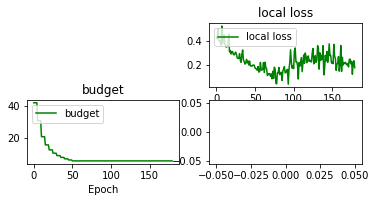

In [ ]:
start_time = time.time()

Loop_accuracy = []
Loop_accuracy =  np.full(args.epoch_period, 0.) 

## stop condition is the number of epochs
for epoch in tqdm(range(args.epochs)):

## stop condition is the total budget  
# while cumulated_budget < total_rho:

## stop condition is the loss threshold 
# while local_loss > Min_Loss_trashold:

  # if cumulated_budget >  total_rho:
  #   break
  # if local_loss <  Min_Loss_trashold:
  #   break
  number_of_iterations = ((endingTime - beginningTime)//args.trainingInterval)+1
  for iteration in tqdm(range(number_of_iterations)):
    timestamp = random.randrange(beginningTime, endingTime, args.trainingInterval)
    # if local_loss <  Min_Loss_trashold:
    #   break
    # if cumulated_budget >  total_rho:
    #   break
    # train the local model
    # apply privacy if specified on the local model
    quotient = number_of_training_rounds // args.epoch_period
    remainder = number_of_training_rounds % args.epoch_period

    if args.PrivacyMode == "Increase":
      if quotient == 0:
        privacy_budgets = epsilon_t
        privacy_rho = dp_to_zcdp(privacy_budgets,delta_t)
      else:
        if remainder == 0:
          budget = update_budget_increase(quotient, args)
          privacy_budgets = budget 
          privacy_rho = dp_to_zcdp(privacy_budgets,delta_t)
      sigma_t = epsilon_to_sigma(privacy_budgets,delta_t)
      local_training_acc,local_loss = pertub_weights(timestamp, LocalTrainData[0], device_model,sigma_t,args)  
      adjusted_budget=privacy_budgets   
      assigned_epsilon.append(privacy_budgets)
      assigned_sigma.append(sigma_t) 
      assigned_rho.append(privacy_rho)
    
    cumulated_budget=compute_cumulated_budget(privacy_rho,cumulated_budget)
    if (local_loss_min > local_loss):
      local_loss_min = local_loss 
    local_training_loss.append(local_loss)
    local_training_accuracy_AE.append(local_training_acc["AE"])
    local_training_accuracy_WMAPE.append(local_training_acc["WMAPE"])
    local_training_accuracy_RMSE.append(local_training_acc["RMSE"])
    number_of_training_rounds += 1
    torch.cuda.empty_cache()
    gc.collect()
  print("cumulated_budget:",cumulated_budget)

exec_average_local_training_loss.append(sum(local_training_loss)/ number_of_training_rounds)
exec_average_local_RMSE.append(sum(local_training_accuracy_RMSE) / number_of_training_rounds)
exec_average_local_WMAPE.append(sum(local_training_accuracy_WMAPE) / number_of_training_rounds)
exec_average_local_AE.append(sum(local_training_accuracy_AE) / number_of_training_rounds)
print("\n cumulated_budget:",  cumulated_budget)
total_budget = 0.
number_of_training_rounds = 0
#begin of executions

print("local_loss_min,",local_loss_min)

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

output_results(args,exec_average_local_RMSE,exec_average_local_WMAPE,exec_average_local_AE,
      device_model, LocalTestData, local_training_loss, assigned_sigma)

**Concentrated**

  0%|          | 0/30 [00:00<?, ?it/s]


 eps_nmax: 0.13333333333333333

 rho_nmax: 0.0002890715021936734

 rho_ng: 0.0002890715021936734
local_loss: 0.7372727155840645


/home/fatimazahraerrounda/Downloads/AdaVFL/WeightTools.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  copy.add_(1.,torch.normal(mean=0, std=(sigma * clipping_threshold)/batch_size,size=copy.shape))

  3%|▎         | 1/30 [00:02<01:24,  2.93s/it]

local_loss: 0.7825828584997604



  7%|▋         | 2/30 [00:05<01:23,  2.97s/it]

local_loss: 0.7514613621557752



 10%|█         | 3/30 [00:08<01:19,  2.94s/it]

local_loss: 0.5803501807846302



 13%|█▎        | 4/30 [00:20<02:24,  5.56s/it]

local_loss: 0.6318601003537575



 17%|█▋        | 5/30 [00:23<02:01,  4.87s/it]

local_loss: 0.6172809201913575



 20%|██        | 6/30 [00:27<01:46,  4.44s/it]

local_loss: 0.7707787168522676



 23%|██▎       | 7/30 [00:30<01:34,  4.11s/it]

local_loss: 0.8509554862976074



 27%|██▋       | 8/30 [00:33<01:25,  3.87s/it]

local_loss: 0.6236312833304206



 30%|███       | 9/30 [00:37<01:17,  3.71s/it]

local_loss: 0.5638728158858916



 33%|███▎      | 10/30 [00:40<01:11,  3.59s/it]

local_loss: 0.5022489107971968



 37%|███▋      | 11/30 [00:44<01:08,  3.60s/it]

local_loss: 0.6220780384416381



 40%|████      | 12/30 [00:47<01:02,  3.50s/it]

local_loss: 0.5204298415531715



 43%|████▎     | 13/30 [00:53<01:12,  4.24s/it]

local_loss: 0.5061173923313618



 47%|████▋     | 14/30 [00:56<01:04,  4.00s/it]

local_loss: 0.38833899206171435



 50%|█████     | 15/30 [01:00<00:56,  3.79s/it]

local_loss: 0.5698074921965599



 53%|█████▎    | 16/30 [01:03<00:50,  3.63s/it]

local_loss: 0.4766735089942813



 57%|█████▋    | 17/30 [01:06<00:45,  3.53s/it]

local_loss: 0.4010840331514676



 60%|██████    | 18/30 [01:09<00:41,  3.46s/it]

local_loss: 0.3945816345512867



 63%|██████▎   | 19/30 [01:18<00:54,  5.00s/it]

local_loss: 0.4019319691384832



 67%|██████▋   | 20/30 [01:22<00:45,  4.55s/it]

local_loss: 0.38294348182777566



 70%|███████   | 21/30 [01:25<00:37,  4.21s/it]

local_loss: 0.35272252435485524



 73%|███████▎  | 22/30 [01:28<00:31,  3.96s/it]

local_loss: 0.315115620692571



 77%|███████▋  | 23/30 [01:32<00:26,  3.77s/it]

local_loss: 0.30440677360941965



 80%|████████  | 24/30 [01:36<00:22,  3.80s/it]

local_loss: 0.31544915804018575



 83%|████████▎ | 25/30 [01:42<00:22,  4.60s/it]

local_loss: 0.24888511871298155



 87%|████████▋ | 26/30 [01:46<00:17,  4.32s/it]

local_loss: 0.2740219570696354



 90%|█████████ | 27/30 [01:49<00:12,  4.08s/it]

local_loss: 0.20906504647185406



 93%|█████████▎| 28/30 [01:53<00:07,  3.91s/it]

local_loss: 0.2468272683521112



 97%|█████████▋| 29/30 [01:59<00:04,  4.49s/it]

local_loss: 0.1983926702911655



  0%|          | 0/30 [00:00<?, ?it/s]

total_budget: 0.17470943895598576
local_loss: 0.23506951704621315



  3%|▎         | 1/30 [00:03<01:38,  3.40s/it]

local_loss: 0.21260564650098482



  7%|▋         | 2/30 [00:06<01:35,  3.39s/it]

local_loss: 0.2673419139658411



 10%|█         | 3/30 [00:10<01:35,  3.52s/it]

local_loss: 0.21959721421202025



 13%|█▎        | 4/30 [00:14<01:30,  3.49s/it]

local_loss: 0.195087106898427



 17%|█▋        | 5/30 [00:20<01:46,  4.26s/it]

local_loss: 0.22780806757509708



 20%|██        | 6/30 [00:23<01:36,  4.04s/it]

local_loss: 0.17249366734176874



 23%|██▎       | 7/30 [00:26<01:28,  3.84s/it]

local_loss: 0.18828549173971018



 27%|██▋       | 8/30 [00:30<01:21,  3.69s/it]

local_loss: 0.10595833075543244



 30%|███       | 9/30 [00:33<01:15,  3.60s/it]

local_loss: 0.15891557931900024



 33%|███▎      | 10/30 [00:37<01:10,  3.52s/it]

local_loss: 0.17490335181355476



 37%|███▋      | 11/30 [00:40<01:08,  3.61s/it]

local_loss: 0.19383682496845722



 40%|████      | 12/30 [00:44<01:03,  3.55s/it]

local_loss: 0.16793628378460804



 43%|████▎     | 13/30 [00:50<01:12,  4.28s/it]

local_loss: 0.16485453210771084



 47%|████▋     | 14/30 [00:53<01:04,  4.04s/it]

local_loss: 0.2522060889750719



 50%|█████     | 15/30 [00:57<00:57,  3.83s/it]

local_loss: 0.0936340307816863



 53%|█████▎    | 16/30 [01:00<00:51,  3.69s/it]

local_loss: 0.3227522186934948



 57%|█████▋    | 17/30 [01:06<00:56,  4.33s/it]

local_loss: 0.0788864487161239



 60%|██████    | 18/30 [01:09<00:48,  4.06s/it]

local_loss: 0.16353851494689783



 63%|██████▎   | 19/30 [01:13<00:43,  3.96s/it]

local_loss: 0.4423848471293847



 67%|██████▋   | 20/30 [01:16<00:37,  3.78s/it]

local_loss: 0.5108896043772498



 70%|███████   | 21/30 [01:20<00:33,  3.69s/it]

local_loss: 0.08569794769088428



 73%|███████▎  | 22/30 [01:23<00:28,  3.58s/it]

local_loss: 0.4728641454130411



 77%|███████▋  | 23/30 [01:27<00:24,  3.55s/it]

local_loss: 0.20219932061930498



 80%|████████  | 24/30 [01:30<00:21,  3.50s/it]

local_loss: 0.24639123988648257



 83%|████████▎ | 25/30 [01:33<00:17,  3.46s/it]

local_loss: 0.267985080058376



 87%|████████▋ | 26/30 [01:37<00:13,  3.44s/it]

local_loss: 0.41702708324720694



 90%|█████████ | 27/30 [01:40<00:10,  3.40s/it]

local_loss: 0.034447669982910156



 93%|█████████▎| 28/30 [01:44<00:07,  3.52s/it]

local_loss: 0.28571029628316563



 97%|█████████▋| 29/30 [01:47<00:03,  3.49s/it]

local_loss: 0.23997302229205766



  0%|          | 0/30 [00:00<?, ?it/s]

total_budget: 0.1338156300570408
local_loss: 0.3709776295969884



  3%|▎         | 1/30 [00:04<02:08,  4.44s/it]

local_loss: 0.23682818872233233



  7%|▋         | 2/30 [00:15<03:02,  6.52s/it]

local_loss: 0.3161694463342428



 10%|█         | 3/30 [00:23<03:08,  6.98s/it]

local_loss: 0.07377183437347412



 13%|█▎        | 4/30 [00:29<02:49,  6.51s/it]

local_loss: 0.4640919919623885



 17%|█▋        | 5/30 [00:33<02:23,  5.73s/it]

local_loss: 0.4708128786364267



 20%|██        | 6/30 [00:38<02:11,  5.50s/it]

local_loss: 0.37559775697688264



 23%|██▎       | 7/30 [00:42<02:01,  5.27s/it]

local_loss: 0.30273257568478584



 27%|██▋       | 8/30 [00:46<01:42,  4.68s/it]

local_loss: 0.3073319084942341



 30%|███       | 9/30 [00:49<01:30,  4.29s/it]

local_loss: 0.3215451867630084



 33%|███▎      | 10/30 [00:53<01:22,  4.10s/it]

local_loss: 0.17318659896651903



 37%|███▋      | 11/30 [00:56<01:13,  3.88s/it]

local_loss: 0.45936912174026173



 40%|████      | 12/30 [01:00<01:08,  3.82s/it]

local_loss: 0.09433114528656006



 43%|████▎     | 13/30 [01:03<01:01,  3.62s/it]

local_loss: 0.326138839746515



 47%|████▋     | 14/30 [01:06<00:56,  3.52s/it]

local_loss: 0.2841990838448207



 50%|█████     | 15/30 [01:10<00:52,  3.51s/it]

local_loss: 0.31458545848727226



 53%|█████▎    | 16/30 [01:18<01:08,  4.86s/it]

local_loss: 0.2858729014794032



 57%|█████▋    | 17/30 [01:21<00:57,  4.46s/it]

local_loss: 0.38567113938430947



 60%|██████    | 18/30 [01:24<00:49,  4.10s/it]

local_loss: 0.38567113938430947



 63%|██████▎   | 19/30 [01:28<00:42,  3.85s/it]

local_loss: 0.4853751319785451



 67%|██████▋   | 20/30 [01:35<00:47,  4.75s/it]

local_loss: 0.18206912900010744



 70%|███████   | 21/30 [01:40<00:43,  4.88s/it]

local_loss: 0.40573813517888385



 73%|███████▎  | 22/30 [01:44<00:38,  4.80s/it]

local_loss: 0.3083355315029621



 77%|███████▋  | 23/30 [01:49<00:33,  4.72s/it]

local_loss: 0.3806101909528176



 80%|████████  | 24/30 [01:54<00:28,  4.77s/it]

local_loss: 0.3202176721145709



 83%|████████▎ | 25/30 [01:59<00:24,  4.82s/it]

local_loss: 0.48056176582048105



 87%|████████▋ | 26/30 [02:05<00:20,  5.15s/it]

local_loss: 0.17373723102112612



 90%|█████████ | 27/30 [02:13<00:18,  6.06s/it]

local_loss: 0.3178296151260535



 93%|█████████▎| 28/30 [02:17<00:11,  5.62s/it]

local_loss: 0.31467305185894173



 97%|█████████▋| 29/30 [02:23<00:05,  5.46s/it]

local_loss: 0.3155121865371863



  0%|          | 0/30 [00:00<?, ?it/s]

total_budget: 0.07142863121970747
local_loss: 0.46760077739870826



  3%|▎         | 1/30 [00:04<02:20,  4.83s/it]

local_loss: 0.07480728626251221



  7%|▋         | 2/30 [00:09<02:14,  4.79s/it]

local_loss: 0.29907960010071594



 10%|█         | 3/30 [00:14<02:08,  4.78s/it]

local_loss: 0.38781951802472275



 13%|█▎        | 4/30 [00:23<02:38,  6.10s/it]

local_loss: 0.4237632391353448



 17%|█▋        | 5/30 [00:31<02:49,  6.78s/it]

local_loss: 0.37173674379785854



 20%|██        | 6/30 [00:36<02:29,  6.24s/it]

local_loss: 0.28801200228432816



 23%|██▎       | 7/30 [00:41<02:12,  5.75s/it]

local_loss: 0.27282999518016976



 27%|██▋       | 8/30 [00:44<01:51,  5.09s/it]

local_loss: 0.25356780365109444



 30%|███       | 9/30 [00:48<01:36,  4.59s/it]

local_loss: 0.20271421037614346



 33%|███▎      | 10/30 [00:53<01:37,  4.87s/it]

local_loss: 0.24119066074490547



 37%|███▋      | 11/30 [00:57<01:24,  4.44s/it]

local_loss: 0.24860626769562563



 40%|████      | 12/30 [01:01<01:17,  4.29s/it]

local_loss: 0.09946877385179202



 43%|████▎     | 13/30 [01:05<01:10,  4.16s/it]

local_loss: 0.2953705545514822



 47%|████▋     | 14/30 [01:08<01:03,  3.96s/it]

local_loss: 0.0028977394104003906



 50%|█████     | 15/30 [01:11<00:55,  3.70s/it]

local_loss: 0.2699052958438794



 53%|█████▎    | 16/30 [01:14<00:49,  3.57s/it]

local_loss: 0.22357485443353653



 57%|█████▋    | 17/30 [01:18<00:45,  3.48s/it]

local_loss: 0.18294463555018106



 60%|██████    | 18/30 [01:21<00:41,  3.48s/it]

local_loss: 0.0840095542371273



 63%|██████▎   | 19/30 [01:25<00:37,  3.45s/it]

local_loss: 0.08178913220763206



 67%|██████▋   | 20/30 [01:28<00:35,  3.55s/it]

local_loss: 0.20354726041356722



 70%|███████   | 21/30 [01:31<00:30,  3.38s/it]

local_loss: 0.0756842823078235



 73%|███████▎  | 22/30 [01:35<00:28,  3.52s/it]

local_loss: 0.29183714588483173



 77%|███████▋  | 23/30 [01:39<00:24,  3.49s/it]

local_loss: 0.23183839519818625



 80%|████████  | 24/30 [01:42<00:20,  3.49s/it]

local_loss: 0.049836933612823486


  0%|          | 0/30 [00:00<?, ?it/s]

total_budget: -0.0008315251673036354
local_loss: 0.22273364383727312


  0%|          | 0/30 [00:00<?, ?it/s]

total_budget: -0.003998101826965366
local_loss: 0.20747936330735683


 10%|█         | 1/10 [00:00<00:01,  5.60it/s]

total_budget: -0.007164678486627096

 total_budget: -0.007164678486627096
local_loss_min, 0.0028977394104003906

 Total Run Time: 495.0719
Training RMSEs 0.38403355446898646
0.38403355446898646
Training WMAPEs 0.42974644271950974
0.42974644271950974
Training AEs 0.05205892126909212
0.05205892126909212


100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


Testing RMSEs 0.473957880087316
0.6357152086384412
0.3067361112005938
0.21539621413004423
0.486273306702377
0.48968154010176684
0.7128758259112453
0.5772533547298577
0.39429608503110997
0.5043894498851622
0.4169617045425616
Testing WMAPEs 0.5083056658506393
0.8108060359954834
0.1852826178073883
0.1444748342037201
0.531304121017456
0.48056596517562866
0.9377213716506958
0.7063713669776917
0.303510844707489
0.5690378546714783
0.4139816462993622
Testing AEs 0.28533049747347833
0.44852200150489807
0.06504455208778381
0.034390680491924286
0.31713372468948364
0.2961515486240387
0.5128617286682129
0.40251731872558594
0.1783527433872223
0.3402070701122284
0.25812360644340515


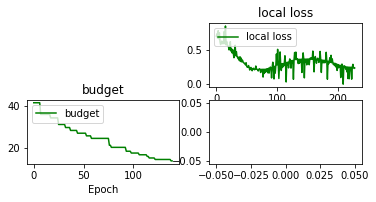

In [ ]:
import math
import copy
if args.PrivacyMode == "Concentrated":
  eps_nmax =  (total_epsilon * 0.5) / args.epochs
  print("\n eps_nmax:",eps_nmax)
  rho_nmax = rho_t
  print("\n rho_nmax:",rho_nmax)
  rho_ng = rho_nmax
  print("\n rho_ng:",rho_ng)
  rho = 4*total_rho
  chosen_step_sizes = []
  max_step_size =0.001
  n_candidate = 5
  exp_dec = 1.0


# initialize variables for the training:
start_time = time.time()

for epoch in tqdm(range(args.epochs)):
# while cumulated_budget <total_rho:
# while local_loss > Min_Loss_trashold:
  # if cumulated_budget >  total_rho:
  #   break
  number_of_iterations = ((endingTime - beginningTime)//args.trainingInterval)+1
  for iteration in tqdm(range(number_of_iterations)):
    timestamp = random.randrange(beginningTime, endingTime, args.trainingInterval)
    # if local_loss <  Min_Loss_trashold:
    #   break
    # if cumulated_budget > total_rho:
    #   break
    # train the local model
    # apply privacy if specified on the local model
    if args.PrivacyMode == "Concentrated":
      # if rho < 0:
      #   break
      # non-private (clipped) gradient
      local_training_acc,local_loss = grad_func(timestamp, LocalTrainData[0], device_model, args)
      sigma = rho_to_sigma(rho_ng)
      rho -= rho_nmax
      idx = 0
      noisy_grad = perturb_gradients(device_model,sigma,args.clipping_threshold, args.batch_size)
      model_copy=copy.deepcopy(device_model)
      while idx == 0:
        step_sizes = np.linspace(0, max_step_size, n_candidate+1)
        candidate = build_candidates(model_copy, noisy_grad, step_sizes)
        scores = [loss_score(model_copy, theta, LocalValidationData[0], args.obj_clip,args)
                    for theta in candidate]
        scores[0] *= exp_dec
        lmbda = args.obj_clip/math.sqrt(2.0 * rho_nmax)
        idx, _= noisyMax(scores, lmbda, bmin=True)
        rho -= rho_nmax
        # used up the budget
        # if rho < 0:
        #   break
        if idx > 0:
          # don't do the update when the remain budget is insufficient
          if rho >= 0:
            override_model(device_model, candidate[idx-1])
            local_training_loss.append(scores[idx])
          rho -= rho_ng
          privacy_budgets = rho_to_dp(rho_ng,delta_t)   
          assigned_epsilon.append(privacy_budgets)
          assigned_sigma.append(sigma)
          assigned_rho.append(rho_ng)
          # if rho < 0:
          #   break
        else:
          rho_old = rho_ng
          rho_ng *= (1.0 + args.gamma)
          noisy_grad = grad_avg(rho_old, rho_ng, device_model, noisy_grad, args)
          sum = 0.
          for n_grad in noisy_grad:
            sum += torch.linalg.norm(n_grad)
          norm = math.sqrt(sum)
          for n_grad in noisy_grad:
            n_grad /= norm
          rho -= (rho_ng - rho_old)
          privacy_budgets = rho_to_dp(rho_ng,delta_t)   
          assigned_epsilon.append(privacy_budgets)
          assigned_sigma.append(sigma)
          assigned_rho.append(rho_ng)
          # if rho < 0:
          #   break
      
      chosen_step_sizes.append(step_sizes[idx])
      if (number_of_training_rounds % 10) == 0:
        max_step_size = min(1.1*max(chosen_step_sizes), 2.0)
        del chosen_step_sizes[:]
      if rho < 0:
        break 
      total_budget= rho
      if (local_loss_min > local_loss):
        local_loss_min = local_loss 
    local_training_loss.append(local_loss)
    local_training_accuracy_AE.append(local_training_acc["AE"])
    local_training_accuracy_WMAPE.append(local_training_acc["WMAPE"])
    local_training_accuracy_RMSE.append(local_training_acc["RMSE"])
    number_of_training_rounds += 1
    torch.cuda.empty_cache()
    gc.collect()

exec_average_local_training_loss.append(np.sum(local_training_loss)/ number_of_training_rounds)
exec_average_local_RMSE.append(np.sum(local_training_accuracy_RMSE) / number_of_training_rounds)
exec_average_local_WMAPE.append(np.sum(local_training_accuracy_WMAPE) / number_of_training_rounds)
exec_average_local_AE.append(np.sum(local_training_accuracy_AE) / number_of_training_rounds)

print("\n total_budget:",  rho)
total_budget = 0.
number_of_training_rounds = 0
#begin of executions

print("local_loss_min,",local_loss_min)

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

output_results(args,exec_average_local_RMSE,exec_average_local_WMAPE,exec_average_local_AE,
      device_model, LocalTestData, local_training_loss, assigned_sigma)


**Adaptive**

  0%|          | 0/30 [00:00<?, ?it/s]/home/fatimazahraerrounda/Downloads/AdaVFL/Models.py:119: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  per_sample_grad.add_(1.,torch.normal(mean=0, std=noise * self.args.clipping_threshold,size=per_sample_grad.shape))

  3%|▎         | 1/30 [00:00<00:23,  1.23it/s]

local_loss  0.37423497484996915



  7%|▋         | 2/30 [00:01<00:24,  1.14it/s]

local_loss  0.39349491459627944



 10%|█         | 3/30 [00:02<00:23,  1.14it/s]

local_loss  0.413408968752871



 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]

local_loss  0.3535260741676514



 17%|█▋        | 5/30 [00:05<00:26,  1.04s/it]

local_loss  0.4897485949719946



 20%|██        | 6/30 [00:06<00:25,  1.05s/it]

local_loss  0.40661520790308714
local_loss  0.35164041848232347



 27%|██▋       | 8/30 [00:08<00:23,  1.05s/it]

local_loss  0.3044034840228657



 30%|███       | 9/30 [00:09<00:21,  1.02s/it]

local_loss  0.2951940489001572
local_loss  0.4080413073922197



 37%|███▋      | 11/30 [00:11<00:18,  1.02it/s]

local_loss  0.2965033029516538



 40%|████      | 12/30 [00:12<00:17,  1.05it/s]

local_loss  0.2660132674500346



 43%|████▎     | 13/30 [00:12<00:15,  1.07it/s]

local_loss  0.3174229363600413



 47%|████▋     | 14/30 [00:13<00:14,  1.09it/s]

local_loss  0.2699316975682281



 50%|█████     | 15/30 [00:14<00:13,  1.10it/s]

local_loss  0.40589866787195206



 53%|█████▎    | 16/30 [00:15<00:12,  1.10it/s]

local_loss  0.24273912453403076



 57%|█████▋    | 17/30 [00:16<00:11,  1.10it/s]

local_loss  0.23726116555432478



 60%|██████    | 18/30 [00:17<00:10,  1.10it/s]

local_loss  0.21770372800529003



 63%|██████▎   | 19/30 [00:18<00:09,  1.11it/s]

local_loss  0.29660437318185967



 67%|██████▋   | 20/30 [00:19<00:08,  1.12it/s]

local_loss  0.202698382238547



 70%|███████   | 21/30 [00:20<00:08,  1.12it/s]

local_loss  0.21690256459017596



 73%|███████▎  | 22/30 [00:21<00:07,  1.12it/s]

local_loss  0.1974998296548923



 77%|███████▋  | 23/30 [00:21<00:06,  1.11it/s]

local_loss  0.2482033564398686



 80%|████████  | 24/30 [00:22<00:05,  1.11it/s]

local_loss  0.17669997674723467



 83%|████████▎ | 25/30 [00:23<00:04,  1.11it/s]

local_loss  0.21695963483910227



 87%|████████▋ | 26/30 [00:24<00:03,  1.11it/s]

local_loss  0.2316683984051148



 90%|█████████ | 27/30 [00:25<00:02,  1.11it/s]

local_loss  0.24686471497019133



 93%|█████████▎| 28/30 [00:26<00:01,  1.11it/s]

local_loss  0.23459634060660997



 97%|█████████▋| 29/30 [00:27<00:00,  1.12it/s]

local_loss  0.160744937757651



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.15791264114280543
total_budget: 0.018488454987304982



  3%|▎         | 1/30 [00:00<00:26,  1.08it/s]

local_loss  0.15066409980257353



  7%|▋         | 2/30 [00:01<00:25,  1.08it/s]

local_loss  0.16269233915954828



 10%|█         | 3/30 [00:02<00:24,  1.08it/s]

local_loss  0.16462959131846824



 13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]

local_loss  0.1456238099684318



 17%|█▋        | 5/30 [00:04<00:24,  1.04it/s]

local_loss  0.1539833297332128



 20%|██        | 6/30 [00:05<00:22,  1.06it/s]

local_loss  0.15135337505489588



 23%|██▎       | 7/30 [00:06<00:21,  1.08it/s]

local_loss  0.16992759983986616



 27%|██▋       | 8/30 [00:07<00:20,  1.09it/s]

local_loss  0.20021327957510948



 30%|███       | 9/30 [00:08<00:18,  1.11it/s]

local_loss  0.08501290219525497



 33%|███▎      | 10/30 [00:09<00:17,  1.11it/s]

local_loss  0.15620441486438116



 37%|███▋      | 11/30 [00:10<00:16,  1.12it/s]

local_loss  0.1275038874397675



 40%|████      | 12/30 [00:10<00:16,  1.12it/s]

local_loss  0.12223864688227574



 43%|████▎     | 13/30 [00:11<00:15,  1.12it/s]

local_loss  0.21043356880545616
local_loss  0.06615559135874112



 50%|█████     | 15/30 [00:13<00:13,  1.13it/s]

local_loss  0.144157360928754



 53%|█████▎    | 16/30 [00:14<00:12,  1.13it/s]

local_loss  0.22300421198209128



 57%|█████▋    | 17/30 [00:15<00:11,  1.13it/s]

local_loss  0.09026323010524114



 60%|██████    | 18/30 [00:16<00:10,  1.12it/s]

local_loss  0.09343188380201657



 63%|██████▎   | 19/30 [00:17<00:09,  1.12it/s]

local_loss  0.21494222525507212



 67%|██████▋   | 20/30 [00:18<00:08,  1.11it/s]

local_loss  0.18986060563474894



 70%|███████   | 21/30 [00:19<00:08,  1.10it/s]

local_loss  0.24553609608362117



 73%|███████▎  | 22/30 [00:19<00:07,  1.11it/s]

local_loss  0.24954606189082065



 77%|███████▋  | 23/30 [00:20<00:06,  1.12it/s]

local_loss  0.20131243020296097



 80%|████████  | 24/30 [00:21<00:05,  1.12it/s]

local_loss  0.16676701915760836



 83%|████████▎ | 25/30 [00:22<00:04,  1.13it/s]

local_loss  0.18337507483859858



 87%|████████▋ | 26/30 [00:23<00:03,  1.13it/s]

local_loss  0.18913612328469753



 90%|█████████ | 27/30 [00:24<00:02,  1.11it/s]

local_loss  0.2537981414546569



 93%|█████████▎| 28/30 [00:25<00:01,  1.11it/s]

local_loss  0.13956353502968946



 97%|█████████▋| 29/30 [00:26<00:00,  1.11it/s]

local_loss  0.24465944804251194



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.28821679173658293
total_budget: 0.0634654898212486



  3%|▎         | 1/30 [00:00<00:25,  1.12it/s]

local_loss  0.15263854215542474



  7%|▋         | 2/30 [00:01<00:24,  1.13it/s]

local_loss  0.23955218183497587
local_loss  0.052038842191298805



 10%|█         | 3/30 [00:02<00:24,  1.10it/s]

local_loss  0.3319271619742115



 17%|█▋        | 5/30 [00:04<00:22,  1.11it/s]

local_loss  0.23467530868947506



 20%|██        | 6/30 [00:05<00:21,  1.10it/s]

local_loss  0.13651986978948116



 23%|██▎       | 7/30 [00:06<00:21,  1.09it/s]

local_loss  0.2595306333775322



 27%|██▋       | 8/30 [00:07<00:20,  1.07it/s]

local_loss  0.31557049322873354



 30%|███       | 9/30 [00:08<00:19,  1.05it/s]

local_loss  0.26905380468815565
local_loss  0.2668564623842637



 37%|███▋      | 11/30 [00:10<00:17,  1.08it/s]

local_loss  0.27639942647268373
local_loss  0.38371448079124093



 40%|████      | 12/30 [00:11<00:16,  1.10it/s]

local_loss  0.21647686697542667



 47%|████▋     | 14/30 [00:12<00:14,  1.09it/s]

local_loss  0.23211239775021872



 50%|█████     | 15/30 [00:13<00:13,  1.10it/s]

local_loss  0.2715252973139286



 53%|█████▎    | 16/30 [00:14<00:12,  1.10it/s]

local_loss  0.2699008633693059



 57%|█████▋    | 17/30 [00:15<00:11,  1.10it/s]

local_loss  0.23032089664290348



 60%|██████    | 18/30 [00:16<00:10,  1.10it/s]

local_loss  0.3859369158744812



 63%|██████▎   | 19/30 [00:17<00:09,  1.11it/s]

local_loss  0.23001097856710354



 67%|██████▋   | 20/30 [00:18<00:09,  1.10it/s]

local_loss  0.25588407274335623



 70%|███████   | 21/30 [00:19<00:08,  1.11it/s]

local_loss  0.26327961931626004



 73%|███████▎  | 22/30 [00:20<00:07,  1.10it/s]

local_loss  0.22815814645340046



 77%|███████▋  | 23/30 [00:20<00:06,  1.11it/s]

local_loss  0.2668956524382035



 80%|████████  | 24/30 [00:21<00:05,  1.11it/s]

local_loss  0.22607445499549308



 83%|████████▎ | 25/30 [00:22<00:04,  1.11it/s]

local_loss  0.17593703418970108



 87%|████████▋ | 26/30 [00:23<00:03,  1.11it/s]

local_loss  0.26306908080975216



 90%|█████████ | 27/30 [00:24<00:02,  1.12it/s]

local_loss  0.1435218583792448



 93%|█████████▎| 28/30 [00:25<00:01,  1.12it/s]

local_loss  0.2374043163533012



 97%|█████████▋| 29/30 [00:26<00:00,  1.11it/s]

local_loss  0.16932588505248228



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.2558320099487901
total_budget: 0.22708072700601384



  3%|▎         | 1/30 [00:00<00:28,  1.03it/s]

local_loss  0.22518644854426384



  7%|▋         | 2/30 [00:01<00:26,  1.04it/s]

local_loss  0.055493379632631935



 10%|█         | 3/30 [00:02<00:25,  1.06it/s]

local_loss  0.3024978678052624
local_loss  0.32554308014611405



 17%|█▋        | 5/30 [00:04<00:23,  1.08it/s]

local_loss  0.2450179805358251



 20%|██        | 6/30 [00:05<00:22,  1.09it/s]

local_loss  0.25235924186805886



 23%|██▎       | 7/30 [00:06<00:21,  1.09it/s]

local_loss  0.042480657498041786



 27%|██▋       | 8/30 [00:07<00:19,  1.10it/s]

local_loss  0.32360815031583917



 30%|███       | 9/30 [00:08<00:18,  1.11it/s]

local_loss  0.26025011607756215



 33%|███▎      | 10/30 [00:09<00:18,  1.09it/s]

local_loss  0.34539136678601307



 37%|███▋      | 11/30 [00:10<00:17,  1.09it/s]

local_loss  0.30370946942518157



 40%|████      | 12/30 [00:11<00:16,  1.07it/s]

local_loss  0.1019974530984958



 43%|████▎     | 13/30 [00:12<00:16,  1.05it/s]

local_loss  0.3072016433227894



 47%|████▋     | 14/30 [00:12<00:15,  1.06it/s]

local_loss  0.3563393158838153



 50%|█████     | 15/30 [00:13<00:13,  1.07it/s]

local_loss  0.19745589575419822



 53%|█████▎    | 16/30 [00:14<00:12,  1.08it/s]

local_loss  0.09023294722040494
local_loss  0.08450558347006638



 60%|██████    | 18/30 [00:16<00:10,  1.10it/s]

local_loss  0.21027319009105364



 63%|██████▎   | 19/30 [00:17<00:09,  1.10it/s]

local_loss  0.1574857827896873



 67%|██████▋   | 20/30 [00:18<00:09,  1.10it/s]

local_loss  0.1941374484449625



 70%|███████   | 21/30 [00:19<00:08,  1.09it/s]

local_loss  0.18450969457626343



 73%|███████▎  | 22/30 [00:20<00:07,  1.08it/s]

local_loss  0.1854955516755581



 77%|███████▋  | 23/30 [00:21<00:06,  1.08it/s]

local_loss  0.3301265410458048



 80%|████████  | 24/30 [00:22<00:05,  1.08it/s]

local_loss  0.30020075508703786



 83%|████████▎ | 25/30 [00:23<00:04,  1.08it/s]

local_loss  0.25804856854180497
local_loss  0.2668536450973777



 90%|█████████ | 27/30 [00:24<00:02,  1.08it/s]

local_loss  0.07374314032495022



 93%|█████████▎| 28/30 [00:25<00:01,  1.09it/s]

local_loss  0.161886604813238
local_loss  0.18482878990471363



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.2578370124101639
total_budget: 0.7182376379680375



  3%|▎         | 1/30 [00:00<00:26,  1.09it/s]

local_loss  0.28175127257903415



  7%|▋         | 2/30 [00:01<00:25,  1.08it/s]

local_loss  0.2186664342880249
local_loss  0.05668490814665953



 13%|█▎        | 4/30 [00:03<00:24,  1.07it/s]

local_loss  0.07218651287257671
local_loss  0.16354365522662798



 20%|██        | 6/30 [00:05<00:22,  1.07it/s]

local_loss  0.1647166529049476



 23%|██▎       | 7/30 [00:06<00:21,  1.07it/s]

local_loss  0.08680535852909088



 27%|██▋       | 8/30 [00:07<00:20,  1.08it/s]

local_loss  0.16324042404691377



 30%|███       | 9/30 [00:08<00:19,  1.07it/s]

local_loss  0.15603034601857266



 33%|███▎      | 10/30 [00:09<00:18,  1.07it/s]

local_loss  0.12666028862198195



 37%|███▋      | 11/30 [00:10<00:17,  1.06it/s]

local_loss  0.1538574748362104



 40%|████      | 12/30 [00:11<00:17,  1.05it/s]

local_loss  0.16809440528353056
local_loss  0.20402502982566753



 47%|████▋     | 14/30 [00:13<00:15,  1.05it/s]

local_loss  0.19759417635699114



 50%|█████     | 15/30 [00:14<00:14,  1.01it/s]

local_loss  0.1368736500541369



 53%|█████▎    | 16/30 [00:15<00:13,  1.03it/s]

local_loss  0.12285210968305667



 57%|█████▋    | 17/30 [00:16<00:12,  1.04it/s]

local_loss  0.09379806990424792



 60%|██████    | 18/30 [00:17<00:11,  1.05it/s]

local_loss  0.1439928151667118
local_loss  0.18324511436124644



 67%|██████▋   | 20/30 [00:18<00:09,  1.07it/s]

local_loss  0.22054711573345717



 70%|███████   | 21/30 [00:19<00:08,  1.07it/s]

local_loss  0.14606897998601198



 73%|███████▎  | 22/30 [00:20<00:07,  1.07it/s]

local_loss  0.15317212790250778



 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]

local_loss  0.14269997738301754



 80%|████████  | 24/30 [00:22<00:05,  1.07it/s]

local_loss  0.1480805870766441



 83%|████████▎ | 25/30 [00:23<00:04,  1.07it/s]

local_loss  0.15614523676534495



 87%|████████▋ | 26/30 [00:24<00:03,  1.07it/s]

local_loss  0.24611779193704328



 90%|█████████ | 27/30 [00:25<00:02,  1.07it/s]

local_loss  0.1425577669094006



 93%|█████████▎| 28/30 [00:26<00:01,  1.06it/s]

local_loss  0.1425973375638326



 97%|█████████▋| 29/30 [00:27<00:00,  1.05it/s]

local_loss  0.1906275156264504



  0%|          | 0/30 [00:00<?, ?it/s]

local_loss  0.27388756194462377
total_budget: 2.481806608922352



  3%|▎         | 1/30 [00:00<00:27,  1.07it/s]

local_loss  0.15261540313561758



  7%|▋         | 2/30 [00:01<00:27,  1.04it/s]

local_loss  0.272639530710876



 10%|█         | 3/30 [00:02<00:25,  1.04it/s]

local_loss  0.23057608042533198



 13%|█▎        | 4/30 [00:03<00:24,  1.05it/s]

local_loss  0.20925731159919916
local_loss  0.14371819390604892



 20%|██        | 6/30 [00:05<00:22,  1.05it/s]

local_loss  0.1228439745803674



 23%|██▎       | 7/30 [00:06<00:21,  1.06it/s]

local_loss  0.1517163266738256



 27%|██▋       | 8/30 [00:07<00:20,  1.06it/s]

local_loss  0.18705476199587187



 30%|███       | 9/30 [00:08<00:19,  1.06it/s]

local_loss  0.14828219761451086



 33%|███▎      | 10/30 [00:09<00:18,  1.06it/s]

local_loss  0.15789018819729486



 37%|███▋      | 11/30 [00:10<00:17,  1.06it/s]

local_loss  0.1634849508603414



 40%|████      | 12/30 [00:11<00:17,  1.05it/s]

local_loss  0.13333811052143574



 43%|████▎     | 13/30 [00:12<00:16,  1.04it/s]

local_loss  0.13608518398056427



 47%|████▋     | 14/30 [00:13<00:15,  1.04it/s]

local_loss  0.16264733796318373



 50%|█████     | 15/30 [00:14<00:14,  1.04it/s]

local_loss  0.18111504024515548



 53%|█████▎    | 16/30 [00:15<00:13,  1.04it/s]

local_loss  0.19900727334121862



 57%|█████▋    | 17/30 [00:16<00:13,  1.01s/it]

local_loss  0.18140953282515207



 60%|██████    | 18/30 [00:17<00:12,  1.03s/it]

local_loss  0.18635657709091902



 63%|██████▎   | 19/30 [00:18<00:11,  1.01s/it]

local_loss  0.20621290616691113



 67%|██████▋   | 20/30 [00:19<00:10,  1.00s/it]

local_loss  0.16318665879468122



 70%|███████   | 21/30 [00:20<00:08,  1.01it/s]

local_loss  0.16553689011683068



 73%|███████▎  | 22/30 [00:21<00:07,  1.02it/s]

local_loss  0.15080807792643705



 77%|███████▋  | 23/30 [00:22<00:06,  1.03it/s]

local_loss  0.1702272454276681
local_loss  0.16110855309913555



 83%|████████▎ | 25/30 [00:24<00:04,  1.01it/s]

local_loss  0.17413165792822838



 87%|████████▋ | 26/30 [00:25<00:03,  1.02it/s]

local_loss  0.17274737606445947



 90%|█████████ | 27/30 [00:26<00:02,  1.02it/s]

local_loss  0.14246517109374204



 93%|█████████▎| 28/30 [00:27<00:01,  1.03it/s]

local_loss  0.1535734673961997



 97%|█████████▋| 29/30 [00:28<00:00,  1.02it/s]

local_loss  0.2242461571780344



  0%|          | 0/10 [00:00<?, ?it/s]

local_loss  0.20809770877971207
total_budget: 7.356912778526601

 total_budget: 7.356912778526601
local_loss_min, 0.042480657498041786

 Total Run Time: 167.6909
Training RMSEs 0.2647108577863615
0.2647108577863615
Training WMAPEs 0.28431659804450143
0.28431659804450143
Training AEs 0.06716734969264103
0.06716734969264103


100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


Testing RMSEs 0.29694826256271445
0.30398107210716413
0.3311172808773099
0.26129660081247374
0.2575086045216417
0.3518159800235549
0.30162818371246186
0.27187452480669255
0.349267216760509
0.25612619188719304
0.2848669701181437
Testing WMAPEs 0.34071530103683473
0.409776508808136
0.32347187399864197
0.2599375545978546
0.3148459792137146
0.38444140553474426
0.4123534560203552
0.3507413864135742
0.3268429636955261
0.3140231966972351
0.31071868538856506
Testing AEs -0.007080529350787401
0.07607430964708328
-0.1362396627664566
-0.15553134679794312
0.013061597011983395
0.011119026690721512
0.10399899631738663
0.054214730858802795
-0.0577370785176754
0.028022414073348045
-0.00778828002512455


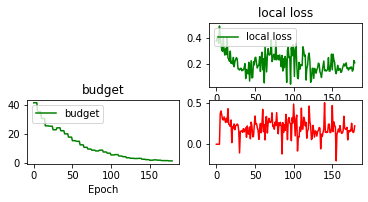

In [ ]:
# device_model = GRU(args)

# initialize variables for the training:
start_time = time.time()
assigned_budget = []
assigned_sigma = []

minimum_training_accuracy = 0.08
Loop_accuracy = []
Loop_accuracy =  np.full(args.epoch_period, 0.) 
Min_Loss_trashold = 0.06
number_epochs = 0
# Min_AE_trashold = -0.1

## stop condition is the number of epochs
for epoch in tqdm(range(args.epochs)):

## stop condition is the total budget  
# while cumulated_budget < total_budget:

## stop condition is the loss threshold 
# while local_loss > Min_Loss_trashold:
  number_epochs+=1
  # if cumulated_budget >  total_budget:
  #   break
  # if local_loss <  Min_Loss_trashold:
  #   break
  number_of_iterations = ((endingTime - beginningTime)//args.trainingInterval)+1
  for iteration in tqdm(range(number_of_iterations)):
    timestamp = random.randrange(beginningTime, endingTime, args.trainingInterval)
    # if local_loss <  Min_Loss_trashold:
    #   break
    # if cumulated_budget >  total_budget:
    #   break
    # train the local model
    # apply privacy if specified on the local model
    # train the local model
    # apply privacy if specified on the local model
    quotient = number_of_training_rounds // args.epoch_period
    remainder = number_of_training_rounds % args.epoch_period
    if args.PrivacyMode ==  "Adaptive":
      if args.AdaptiveError == "Training":
        if quotient == 0:
          if(number_of_training_rounds == 0):
            Loop_accuracy[remainder] = 0.
            # minimum_training_accuracy = 0.2 #loss
            privacy_budgets = rho_t
            # minimum_training_accuracy = 0.2 #RMSE
            # minimum_training_accuracy = 0.1 #MAE
          else:
            # Loop_accuracy[remainder] = local_training_acc[args.validation_accuracy_metric]
            Loop_accuracy[remainder] = local_loss
            # if minimum_training_accuracy > local_training_acc[args.trining_accuracy_metric]:
            #   minimum_training_accuracy = local_training_acc[args.trining_accuracy_metric]  
          args.tracked_error.append(0.)
        else:
          # if minimum_training_accuracy > local_training_acc[args.trining_accuracy_metric]:
          #     minimum_training_accuracy = local_training_acc[args.trining_accuracy_metric]
          if remainder == 0:
            error, budget = update_budget_training(privacy_budgets, local_loss, Loop_accuracy, minimum_training_accuracy, args)
            args.tracked_error.append(error)
            privacy_budgets = budget
          else:
            # args.tracked_error.append(local_training_acc[args.trining_accuracy_metric])
            # Loop_accuracy[remainder] = local_training_acc[args.trining_accuracy_metric]
            args.tracked_error.append(local_loss)
            Loop_accuracy[remainder] = local_loss
      sigma_t = rho_to_sigma(privacy_budgets)    
      local_training_acc,local_loss = pertub_weights(timestamp, LocalTrainData[0], device_model,sigma_t,args)  
      print("local_loss ",local_loss)
      adjusted_budget=rho_to_dp(privacy_budgets,delta_t)   
      assigned_sigma.append(sigma_t)
      assigned_epsilon.append(adjusted_budget)  
      assigned_rho.append(privacy_budgets)
      local_ae = local_training_acc["AE"]
      cumulated_budget=compute_cumulated_budget(privacy_budgets,cumulated_budget)
      if (local_loss_min > local_loss):
        local_loss_min = local_loss 
    local_training_loss.append(local_loss)
    local_training_accuracy_AE.append(local_training_acc["AE"])
    local_training_accuracy_WMAPE.append(local_training_acc["WMAPE"])
    local_training_accuracy_RMSE.append(local_training_acc["RMSE"])
    number_of_training_rounds += 1
    torch.cuda.empty_cache()
    gc.collect()
  print("total_budget:",cumulated_budget)

exec_average_local_training_loss.append(sum(local_training_loss)/ number_of_training_rounds)
exec_average_local_RMSE.append(sum(local_training_accuracy_RMSE) / number_of_training_rounds)
exec_average_local_WMAPE.append(sum(local_training_accuracy_WMAPE) / number_of_training_rounds)
exec_average_local_AE.append(sum(local_training_accuracy_AE) / number_of_training_rounds)
print("\n total_budget:",  cumulated_budget)
# total_budget = 0.
# number_of_training_rounds = 0
#begin of executions

print("local_loss_min,",local_loss_min)

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

output_results(args,exec_average_local_RMSE,exec_average_local_WMAPE,exec_average_local_AE,
      device_model, LocalTestData, local_training_loss, assigned_sigma)

